**Table of contents**<a id='toc0_'></a>    
- [Dataloading](#toc1_)    
- [Utils](#toc2_)    
- [Comparison between Gaussian(1,2) and Normal Distribution](#toc3_)    
  - [Normal VAE](#toc3_1_)    
  - [Gaussian VAE](#toc3_2_)    
- [Improving Samples from Gaussian(1,2) Distribution](#toc4_)    
  - [Changing Initialization](#toc4_1_)    
  - [MSE Loss as Reconstruction Loss](#toc4_2_)    
  - [MAE Loss as Reconstruction Loss](#toc4_3_)    
  - [Perceptual Loss as Reconstruction Loss](#toc4_4_)    
  - [Weighted Perceptual Loss with BCE Loss as Reconstruction Loss](#toc4_5_)    
  - [Weighted Perceptual Loss with MSE Loss as Reconstruction Loss](#toc4_6_)    
- [Reconstructions](#toc5_)    
  - [BCE Loss](#toc5_1_)    
  - [Weighted Perceptual Loss with BCE Loss](#toc5_2_)    
- [10D Latent Space](#toc6_)    
  - [BCE Loss](#toc6_1_)    
  - [Weighted Perceptual Loss with BCE Loss](#toc6_2_)    
- [FID Scores](#toc7_)    
  - [Baselines](#toc7_1_)    
    - [Normal VAE](#toc7_1_1_)    
    - [Gaussian(1,2) VAE](#toc7_1_2_)    
  - [Different Implementations](#toc7_2_)    
    - [Kaiming Init](#toc7_2_1_)    
    - [MAE with Kaiming Init](#toc7_2_2_)    
    - [MSE with Kaiming Init](#toc7_2_3_)    
    - [Perceptual Loss with Kaiming Init](#toc7_2_4_)    
    - [Weighted Perceptual Loss with BCE Loss with Kaiming Init](#toc7_2_5_)    
    - [Weighted Perceptual Loss with MSE Loss with Kaiming Init](#toc7_2_6_)    
  - [10D Latent Space](#toc7_3_)    
    - [BCE Loss](#toc7_3_1_)    
    - [Weighted Perceptual Loss with BCE Loss](#toc7_3_2_)    
- [Additional](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
import torch.nn as nn
from models import BaseVAE,NormalVAE
from trainer import VAETrainer
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import copy
import numpy as np

In [2]:
# Useful constants.
MANUAL_SEED = 42
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
LATENT_DIM = 2
EPOCHS = 15

# <a id='toc1_'></a>[Dataloading](#toc0_)

In [3]:
# Transform
transform = transforms.Compose([transforms.ToTensor()])

# Load the datasets
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# <a id='toc2_'></a>[Utils](#toc0_)

In [4]:

def plot_training_history(training_history: dict):
    epochs = range(1, len(training_history['loss_train']) + 1)
    
    fig, axs = plt.subplots(3,1, figsize=(18, 12))  # Create 3 subplots

    # Plot KLD Loss
    axs[0].plot(epochs, training_history['kld_loss_train'], label='KLD Loss - Train')
    axs[0].plot(epochs, training_history['kld_loss_val'], label='KLD Loss - Validation')
    axs[0].set_title('KLD Loss During Training')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('KLD Loss')
    axs[0].legend()

    # Plot Reconstruction Loss
    axs[1].plot(epochs, training_history['recon_loss_train'], label='Reconstruction Loss - Train')
    axs[1].plot(epochs, training_history['recon_loss_val'], label='Reconstruction Loss - Validation')
    axs[1].set_title('Reconstruction Loss During Training')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Reconstruction Loss')
    axs[1].legend()

    # Plot Total Loss
    axs[2].plot(epochs, training_history['loss_train'], label='Total Loss - Train')
    axs[2].plot(epochs, training_history['loss_val'], label='Total Loss - Validation')
    axs[2].set_title('Total Loss During Training')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Total Loss')
    axs[2].legend()

    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()
    
    
# Function to generate images from latent space
def generate_image(latent_vector, vae_model):
    with torch.no_grad():
        reconstructed_img = vae_model.decode(latent_vector).cpu()
        return ToPILImage()(reconstructed_img.squeeze(0)),reconstructed_img
    
    
def reconstruct(img: torch.Tensor,
                vae_model: BaseVAE):
    img.unsqueeze(0)
    _,_,x_reconstructed = vae_model(img)
    return ToPILImage()(x_reconstructed.squeeze(0)),x_reconstructed
  
def save(model: BaseVAE,
         trainer: VAETrainer,
         path: str):
  """Saves the model weights and its training history."""
  torch.save({
    'state_dict': model.state_dict(),
    'history': trainer.history
  },path)
  
  
def interpolate_and_plot(image1: torch.Tensor, 
                         image2: torch.Tensor, 
                         model: BaseVAE, 
                         steps: int = 10):
    """
    Interpolates between two images using their latent space representations
    and plots the interpolation results.

    Parameters:
    - image1 (torch.Tensor): The first image tensor.
    - image2 (torch.Tensor): The second image tensor.
    - model (torch.nn.Module): The VAE model for encoding and decoding.
    - steps (int): The number of interpolation steps, including the start and end images.
    """
    model.eval()  # Set the model to evaluation mode
    
    # Encode images to latent vectors
    with torch.no_grad():
        image1_param1,image1_param2 = model.encode(image1.unsqueeze(0))
        z1 = model.reparameterise(image1_param1,image1_param2) 
        image2_param1,image2_param2 = model.encode(image2.unsqueeze(0))
        z2 = model.reparameterise(image2_param1,image2_param2) 
        
    # Interpolate in the latent space
    interpolated_z = [z1 * (1 - alpha) + z2 * alpha for alpha in np.linspace(0, 1, steps)]
    
    # Decode the interpolated vectors
    interpolated_images = [model.decode(z).squeeze(0) for z in interpolated_z]
    
    # Plotting
    fig, axes = plt.subplots(1, steps, figsize=(20, 2))
    with torch.no_grad():
        for i, img in enumerate(interpolated_images):
            axes[i].imshow(img.squeeze().cpu().numpy(), cmap='gray')
            axes[i].axis('off')
    plt.show()


def plot_latent_space(model: BaseVAE, 
                      scale: float = 1.0, 
                      n: int = 10, 
                      digit_size: int = 28, 
                      figsize: int =7):
    """
    Visualizes the 2D latent space of a Variational Autoencoder (VAE) by decoding and displaying a grid of sampled points.
    
    Parameters:
    - model (BaseVAE): The trained VAE model whose latent space is to be visualized. 
    - scale (float): The scale of the grid in the latent space. Determines how far from the origin (0,0) the 
      grid extends. Defaults to 1.0, resulting in a grid that extends from -1.0 to 1.0 along both latent dimensions.
    - n (int): The number of grid points per dimension. The total number of images displayed will be n*n. 
      Defaults to 10.
    - digit_size (int): The size (height and width) of each digit/image in pixels. Defaults to 28, suitable 
      for MNIST-like datasets.
    - figsize (int, optional): The size of the figure in which the grid is displayed. Defaults to 7.

    Note:
    - The function assumes the latent space is 2-dimensional. 
    """
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def fetch_digit_indexes(dataset, digits_wanted):
    """
    Fetches the indexes of images in the MNIST dataset that match the specified digits.

    Parameters:
    - dataset (torchvision.datasets.MNIST): The MNIST dataset loaded through torchvision.
    - digits_wanted (list of int): A list of integers representing the digits to find in the dataset.

    Returns:
    - list of int: The indexes of the images in the dataset that match the specified digits.
    """
    indexes = []

    for index, (image, label) in enumerate(dataset):
        if label in digits_wanted:
            indexes.append(index)

    return indexes


# <a id='toc3_'></a>[Comparison between Gaussian(1,2) and Normal Distribution](#toc0_)

In [5]:
torch.manual_seed(MANUAL_SEED)
normal_vae = NormalVAE(LATENT_DIM,prior_mean=0.0,prior_std=1.0)
normal_optimizer = torch.optim.Adam(params=normal_vae.parameters(),lr=LEARNING_RATE)

gaussian_vae = NormalVAE(LATENT_DIM,prior_mean=1.0,prior_std=2.0)
gaussian_vae.load_state_dict(copy.deepcopy(normal_vae.state_dict()))  # Ensuring both vae's have same set of weights.
gaussian_optimizer = torch.optim.Adam(params=gaussian_vae.parameters(),lr=LEARNING_RATE)

reconstruction_loss_fn = torch.nn.BCELoss(reduction='sum')

In [18]:
indexes_6 = fetch_digit_indexes(test_dataset,[6])
indexes_9 = fetch_digit_indexes(test_dataset,[9])

## <a id='toc3_1_'></a>[Normal VAE](#toc0_)

In [6]:
normal_vae_trainer = VAETrainer(
    model=normal_vae,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=normal_optimizer,
    reconstruction_loss_fn=reconstruction_loss_fn,
    device=DEVICE
)

In [7]:
normal_vae_trainer.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:29<00:00, 31.27batch/s, kld_loss=260, loss=6.29e+3, recon_loss=6.03e+3]    


Epoch 1 Training - Total Loss: 263.5799, KLD Loss: 13.7664, Recon Loss: 249.8135


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 72.06batch/s, kld_loss=124, recon_loss=3.13e+3]


Epoch 1 Evaluation - Total Loss: 199.2137, KLD Loss: 7.4698, Recon Loss: 191.7439


Epoch 2/15: 100%|██████████| 938/938 [00:28<00:00, 32.70batch/s, kld_loss=159, loss=5.69e+3, recon_loss=5.53e+3]


Epoch 2 Training - Total Loss: 192.6733, KLD Loss: 5.8131, Recon Loss: 186.8602


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 78.26batch/s, kld_loss=85.8, recon_loss=2.94e+3]


Epoch 2 Evaluation - Total Loss: 187.0212, KLD Loss: 5.0130, Recon Loss: 182.0082


Epoch 3/15: 100%|██████████| 938/938 [00:29<00:00, 31.67batch/s, kld_loss=144, loss=5.69e+3, recon_loss=5.54e+3]


Epoch 3 Training - Total Loss: 182.9009, KLD Loss: 4.8683, Recon Loss: 178.0326


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 45.46batch/s, kld_loss=82.4, recon_loss=2.84e+3]


Epoch 3 Evaluation - Total Loss: 179.2114, KLD Loss: 4.8534, Recon Loss: 174.3580


Epoch 4/15: 100%|██████████| 938/938 [00:29<00:00, 32.10batch/s, kld_loss=150, loss=5.84e+3, recon_loss=5.69e+3]


Epoch 4 Training - Total Loss: 176.9700, KLD Loss: 4.8336, Recon Loss: 172.1365


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 80.05batch/s, kld_loss=81.5, recon_loss=2.77e+3]


Epoch 4 Evaluation - Total Loss: 175.3848, KLD Loss: 4.8582, Recon Loss: 170.5265


Epoch 5/15: 100%|██████████| 938/938 [00:29<00:00, 32.33batch/s, kld_loss=158, loss=5.53e+3, recon_loss=5.37e+3]


Epoch 5 Training - Total Loss: 173.4458, KLD Loss: 4.8536, Recon Loss: 168.5922


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 78.43batch/s, kld_loss=81, recon_loss=2.74e+3] 


Epoch 5 Evaluation - Total Loss: 172.0267, KLD Loss: 4.8931, Recon Loss: 167.1336


Epoch 6/15: 100%|██████████| 938/938 [00:27<00:00, 34.07batch/s, kld_loss=151, loss=5.7e+3, recon_loss=5.55e+3] 


Epoch 6 Training - Total Loss: 170.5356, KLD Loss: 4.8832, Recon Loss: 165.6524


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 81.54batch/s, kld_loss=82.3, recon_loss=2.67e+3]


Epoch 6 Evaluation - Total Loss: 169.5053, KLD Loss: 4.9925, Recon Loss: 164.5127


Epoch 7/15: 100%|██████████| 938/938 [00:28<00:00, 32.59batch/s, kld_loss=156, loss=5.98e+3, recon_loss=5.82e+3]


Epoch 7 Training - Total Loss: 168.4872, KLD Loss: 4.9106, Recon Loss: 163.5766


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.12batch/s, kld_loss=81.5, recon_loss=2.65e+3]


Epoch 7 Evaluation - Total Loss: 167.5697, KLD Loss: 4.9493, Recon Loss: 162.6204


Epoch 8/15: 100%|██████████| 938/938 [00:30<00:00, 30.69batch/s, kld_loss=160, loss=5.37e+3, recon_loss=5.21e+3]


Epoch 8 Training - Total Loss: 167.0079, KLD Loss: 4.8978, Recon Loss: 162.1101


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 79.52batch/s, kld_loss=79.5, recon_loss=2.59e+3]


Epoch 8 Evaluation - Total Loss: 166.3192, KLD Loss: 4.8398, Recon Loss: 161.4794


Epoch 9/15: 100%|██████████| 938/938 [00:29<00:00, 32.24batch/s, kld_loss=164, loss=5.22e+3, recon_loss=5.06e+3]


Epoch 9 Training - Total Loss: 165.9448, KLD Loss: 4.9057, Recon Loss: 161.0391


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 79.85batch/s, kld_loss=81.3, recon_loss=2.56e+3]


Epoch 9 Evaluation - Total Loss: 165.2047, KLD Loss: 4.9746, Recon Loss: 160.2301


Epoch 10/15: 100%|██████████| 938/938 [00:28<00:00, 32.59batch/s, kld_loss=146, loss=4.99e+3, recon_loss=4.84e+3]


Epoch 10 Training - Total Loss: 165.1077, KLD Loss: 4.9323, Recon Loss: 160.1754


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.92batch/s, kld_loss=79.5, recon_loss=2.56e+3]


Epoch 10 Evaluation - Total Loss: 164.5031, KLD Loss: 4.8969, Recon Loss: 159.6061


Epoch 11/15: 100%|██████████| 938/938 [00:29<00:00, 31.79batch/s, kld_loss=157, loss=4.97e+3, recon_loss=4.81e+3]


Epoch 11 Training - Total Loss: 164.3546, KLD Loss: 4.9293, Recon Loss: 159.4254


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 82.70batch/s, kld_loss=79.7, recon_loss=2.57e+3]


Epoch 11 Evaluation - Total Loss: 163.9813, KLD Loss: 4.9090, Recon Loss: 159.0723


Epoch 12/15: 100%|██████████| 938/938 [00:29<00:00, 32.17batch/s, kld_loss=162, loss=5.01e+3, recon_loss=4.84e+3]


Epoch 12 Training - Total Loss: 163.7016, KLD Loss: 4.9444, Recon Loss: 158.7572


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.80batch/s, kld_loss=80.3, recon_loss=2.53e+3]


Epoch 12 Evaluation - Total Loss: 163.1563, KLD Loss: 4.9859, Recon Loss: 158.1705


Epoch 13/15: 100%|██████████| 938/938 [00:28<00:00, 32.70batch/s, kld_loss=169, loss=4.82e+3, recon_loss=4.65e+3]


Epoch 13 Training - Total Loss: 163.1939, KLD Loss: 4.9913, Recon Loss: 158.2027


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 74.00batch/s, kld_loss=80.8, recon_loss=2.5e+3]


Epoch 13 Evaluation - Total Loss: 162.7081, KLD Loss: 5.0207, Recon Loss: 157.6874


Epoch 14/15: 100%|██████████| 938/938 [00:28<00:00, 32.98batch/s, kld_loss=162, loss=5.27e+3, recon_loss=5.11e+3]


Epoch 14 Training - Total Loss: 162.6589, KLD Loss: 5.0000, Recon Loss: 157.6589


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 80.99batch/s, kld_loss=79.9, recon_loss=2.5e+3]


Epoch 14 Evaluation - Total Loss: 162.4770, KLD Loss: 4.9958, Recon Loss: 157.4812


Epoch 15/15: 100%|██████████| 938/938 [00:30<00:00, 31.08batch/s, kld_loss=154, loss=5.49e+3, recon_loss=5.34e+3]


Epoch 15 Training - Total Loss: 162.2450, KLD Loss: 5.0374, Recon Loss: 157.2076


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 74.94batch/s, kld_loss=80.8, recon_loss=2.51e+3]

Epoch 15 Evaluation - Total Loss: 161.7299, KLD Loss: 5.0896, Recon Loss: 156.6403


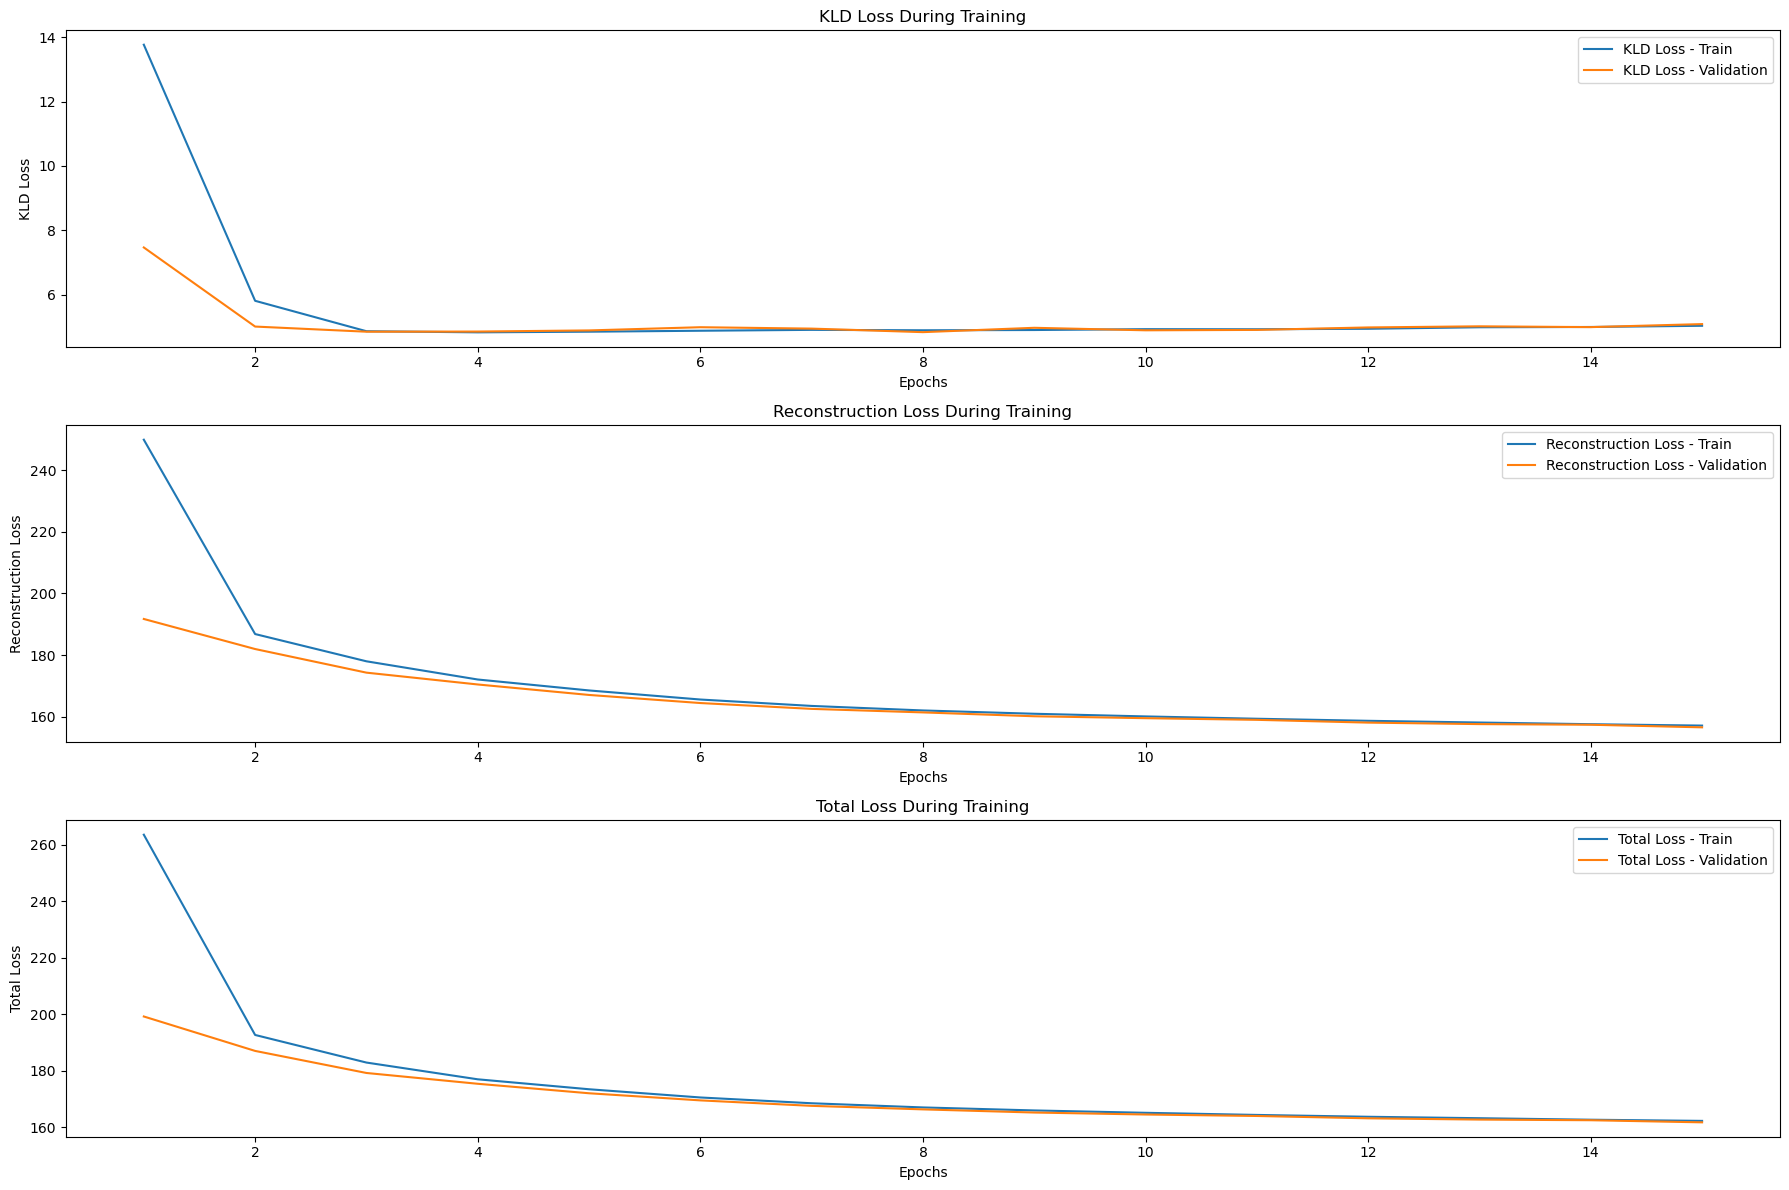

In [9]:
plot_training_history(normal_vae_trainer.history)

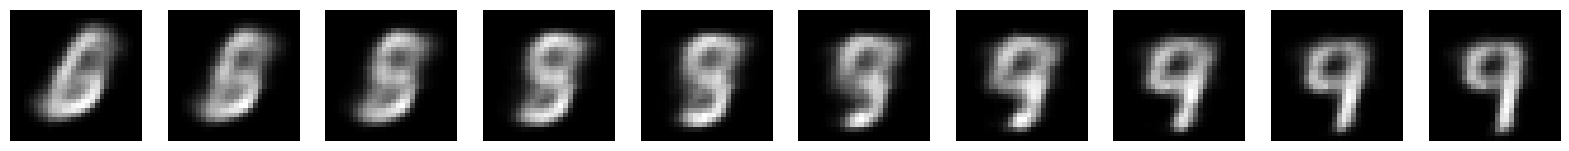

In [49]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,normal_vae)

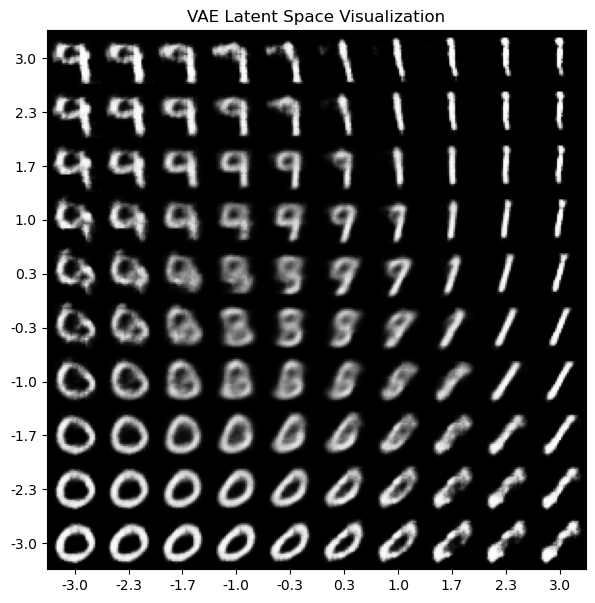

In [51]:
plot_latent_space(normal_vae,scale=3)

In [55]:
save(normal_vae,normal_vae_trainer,'models/normal_vae.pt')

## <a id='toc3_2_'></a>[Gaussian VAE](#toc0_)

In [15]:
gaussian_vae_trainer = VAETrainer(
    model=gaussian_vae,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=gaussian_optimizer,
    reconstruction_loss_fn=reconstruction_loss_fn,
    device=DEVICE
)

In [16]:
gaussian_vae_trainer.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:45<00:00, 20.64batch/s, kld_loss=203, loss=5.85e+3, recon_loss=5.65e+3]    


Epoch 1 Training - Total Loss: 254.4513, KLD Loss: 9.3337, Recon Loss: 245.1177


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 54.64batch/s, kld_loss=87.8, recon_loss=3.19e+3]


Epoch 1 Evaluation - Total Loss: 199.0810, KLD Loss: 5.5277, Recon Loss: 193.5533


Epoch 2/15: 100%|██████████| 938/938 [00:36<00:00, 25.42batch/s, kld_loss=151, loss=6.12e+3, recon_loss=5.97e+3]


Epoch 2 Training - Total Loss: 192.3803, KLD Loss: 4.8839, Recon Loss: 187.4964


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 80.31batch/s, kld_loss=72.2, recon_loss=2.97e+3]


Epoch 2 Evaluation - Total Loss: 187.4517, KLD Loss: 4.5412, Recon Loss: 182.9106


Epoch 3/15: 100%|██████████| 938/938 [00:34<00:00, 27.58batch/s, kld_loss=148, loss=5.18e+3, recon_loss=5.03e+3]


Epoch 3 Training - Total Loss: 185.1316, KLD Loss: 4.3506, Recon Loss: 180.7810


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 69.25batch/s, kld_loss=68.3, recon_loss=2.87e+3]


Epoch 3 Evaluation - Total Loss: 181.4006, KLD Loss: 4.3112, Recon Loss: 177.0894


Epoch 4/15: 100%|██████████| 938/938 [00:29<00:00, 31.62batch/s, kld_loss=133, loss=5.46e+3, recon_loss=5.33e+3]


Epoch 4 Training - Total Loss: 180.2199, KLD Loss: 4.3359, Recon Loss: 175.8840


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 82.53batch/s, kld_loss=68.2, recon_loss=2.85e+3]


Epoch 4 Evaluation - Total Loss: 177.4803, KLD Loss: 4.2928, Recon Loss: 173.1874


Epoch 5/15: 100%|██████████| 938/938 [00:27<00:00, 34.36batch/s, kld_loss=147, loss=5.48e+3, recon_loss=5.33e+3]


Epoch 5 Training - Total Loss: 176.7588, KLD Loss: 4.4038, Recon Loss: 172.3550


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.20batch/s, kld_loss=70.8, recon_loss=2.84e+3]


Epoch 5 Evaluation - Total Loss: 174.6436, KLD Loss: 4.4494, Recon Loss: 170.1943


Epoch 6/15: 100%|██████████| 938/938 [00:29<00:00, 31.88batch/s, kld_loss=153, loss=5.42e+3, recon_loss=5265.75]


Epoch 6 Training - Total Loss: 174.1548, KLD Loss: 4.4823, Recon Loss: 169.6725


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 77.50batch/s, kld_loss=71.7, recon_loss=2.8e+3]


Epoch 6 Evaluation - Total Loss: 172.5408, KLD Loss: 4.5097, Recon Loss: 168.0310


Epoch 7/15: 100%|██████████| 938/938 [00:29<00:00, 31.82batch/s, kld_loss=139, loss=5.47e+3, recon_loss=5.33e+3]


Epoch 7 Training - Total Loss: 172.0623, KLD Loss: 4.5383, Recon Loss: 167.5240


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 81.88batch/s, kld_loss=73.5, recon_loss=2.81e+3]


Epoch 7 Evaluation - Total Loss: 170.8684, KLD Loss: 4.6302, Recon Loss: 166.2382


Epoch 8/15: 100%|██████████| 938/938 [00:28<00:00, 32.94batch/s, kld_loss=153, loss=4.9e+3, recon_loss=4.75e+3] 


Epoch 8 Training - Total Loss: 170.3682, KLD Loss: 4.5996, Recon Loss: 165.7687


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 83.67batch/s, kld_loss=73.8, recon_loss=2.77e+3]


Epoch 8 Evaluation - Total Loss: 169.1884, KLD Loss: 4.6405, Recon Loss: 164.5479


Epoch 9/15: 100%|██████████| 938/938 [00:27<00:00, 33.93batch/s, kld_loss=141, loss=5.72e+3, recon_loss=5.57e+3]


Epoch 9 Training - Total Loss: 168.8351, KLD Loss: 4.6481, Recon Loss: 164.1870


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 83.30batch/s, kld_loss=73.5, recon_loss=2.68e+3]


Epoch 9 Evaluation - Total Loss: 168.0582, KLD Loss: 4.6097, Recon Loss: 163.4485


Epoch 10/15: 100%|██████████| 938/938 [00:28<00:00, 32.82batch/s, kld_loss=150, loss=5.56e+3, recon_loss=5.41e+3]


Epoch 10 Training - Total Loss: 167.5552, KLD Loss: 4.7044, Recon Loss: 162.8507


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 81.03batch/s, kld_loss=74.8, recon_loss=2.66e+3]


Epoch 10 Evaluation - Total Loss: 166.8941, KLD Loss: 4.6893, Recon Loss: 162.2048


Epoch 11/15: 100%|██████████| 938/938 [00:28<00:00, 32.94batch/s, kld_loss=156, loss=5.47e+3, recon_loss=5.31e+3]


Epoch 11 Training - Total Loss: 166.4106, KLD Loss: 4.7620, Recon Loss: 161.6486


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 71.53batch/s, kld_loss=78.1, recon_loss=2.58e+3]


Epoch 11 Evaluation - Total Loss: 165.7380, KLD Loss: 4.8879, Recon Loss: 160.8502


Epoch 12/15: 100%|██████████| 938/938 [00:30<00:00, 31.07batch/s, kld_loss=151, loss=5.51e+3, recon_loss=5.36e+3]


Epoch 12 Training - Total Loss: 165.4130, KLD Loss: 4.8366, Recon Loss: 160.5764


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 47.97batch/s, kld_loss=76.8, recon_loss=2.58e+3]


Epoch 12 Evaluation - Total Loss: 165.0090, KLD Loss: 4.8098, Recon Loss: 160.1992


Epoch 13/15: 100%|██████████| 938/938 [00:28<00:00, 33.00batch/s, kld_loss=161, loss=4.84e+3, recon_loss=4.68e+3]


Epoch 13 Training - Total Loss: 164.5248, KLD Loss: 4.8909, Recon Loss: 159.6339


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 67.68batch/s, kld_loss=78.9, recon_loss=2.54e+3]


Epoch 13 Evaluation - Total Loss: 163.9330, KLD Loss: 4.9306, Recon Loss: 159.0024


Epoch 14/15: 100%|██████████| 938/938 [00:30<00:00, 30.91batch/s, kld_loss=166, loss=5.16e+3, recon_loss=4.99e+3]


Epoch 14 Training - Total Loss: 163.7970, KLD Loss: 4.9566, Recon Loss: 158.8404


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 82.53batch/s, kld_loss=79.3, recon_loss=2.51e+3]


Epoch 14 Evaluation - Total Loss: 163.3713, KLD Loss: 4.9493, Recon Loss: 158.4220


Epoch 15/15: 100%|██████████| 938/938 [00:27<00:00, 34.46batch/s, kld_loss=167, loss=5.02e+3, recon_loss=4.86e+3]


Epoch 15 Training - Total Loss: 163.1429, KLD Loss: 4.9928, Recon Loss: 158.1501


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 82.78batch/s, kld_loss=79.2, recon_loss=2.5e+3]


Epoch 15 Evaluation - Total Loss: 162.8149, KLD Loss: 4.9579, Recon Loss: 157.8570


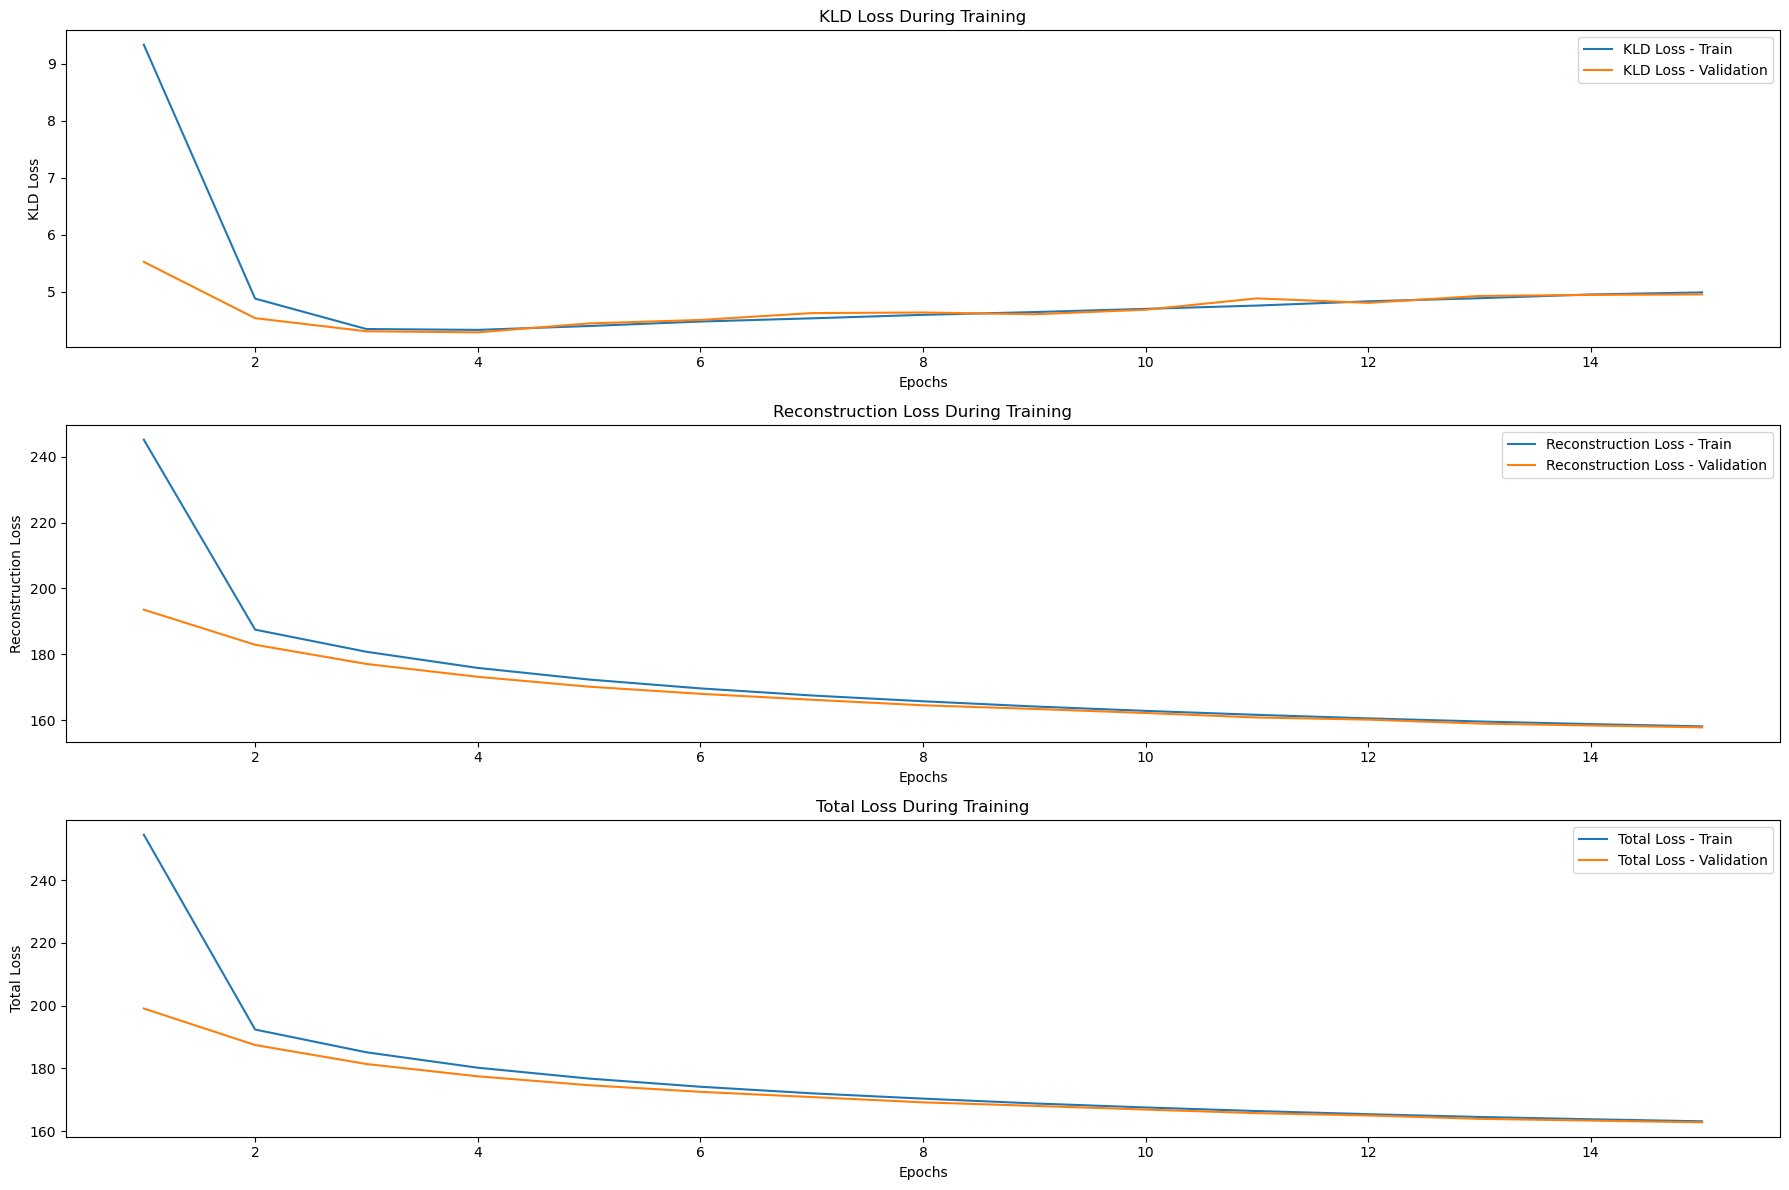

In [18]:
plot_training_history(gaussian_vae_trainer.history)

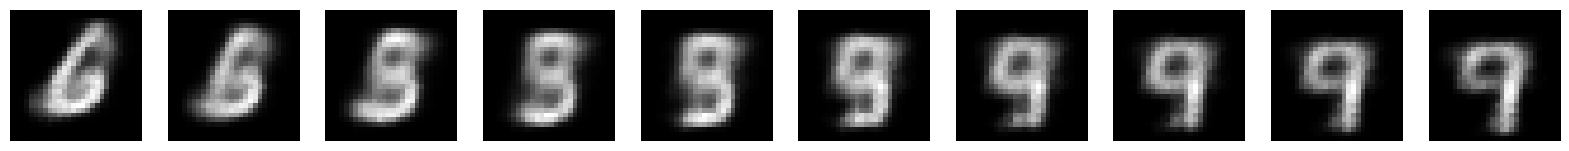

In [54]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,model=gaussian_vae)

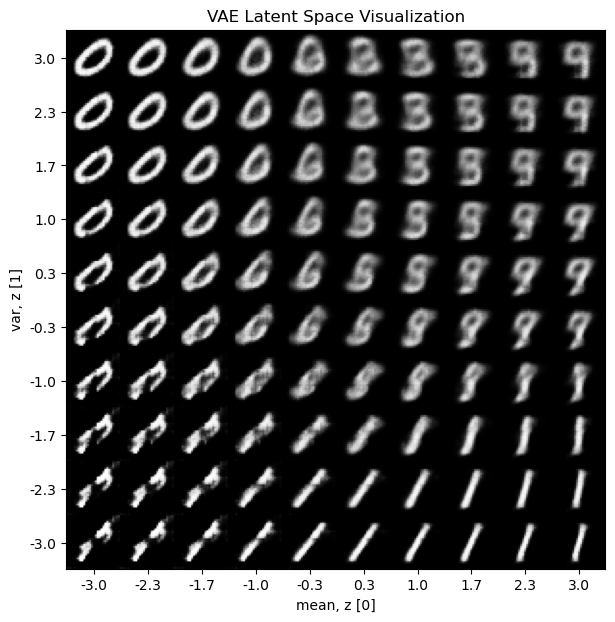

In [25]:
plot_latent_space(gaussian_vae,scale=3)

In [56]:
save(normal_vae,normal_vae_trainer,'models/gaussian(1,2)_vae.pt')

# <a id='toc4_'></a>[Improving Samples from Gaussian(1,2) Distribution](#toc0_)

I won't be increasing the number of epochs or changing the leaerning rate for this. Will work on finding other methods to improve samples.

## <a id='toc4_1_'></a>[Changing Initialization](#toc0_)

Used Kaiming normal

In [5]:
def initialize_weights(model: nn.Module):
    """Initialise weights with kaiming initialisation."""
    for m in model.modules():
        if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear):
            nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias,0)

In [17]:
torch.manual_seed(MANUAL_SEED)
gaussian_vae_init = NormalVAE(LATENT_DIM,1,2)
gaussian_optimizer_init = torch.optim.Adam(gaussian_vae_init.parameters(),lr=LEARNING_RATE)

initialize_weights(gaussian_vae_init)

reconstruction_loss_fn = nn.BCELoss(reduction='sum')

In [18]:
gaussian_vae_trainer_init = VAETrainer(
    model=gaussian_vae_init,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=gaussian_optimizer_init,
    reconstruction_loss_fn=reconstruction_loss_fn,
    device=DEVICE
)

In [19]:
gaussian_vae_trainer_init.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:28<00:00, 32.96batch/s, kld_loss=204, loss=5.93e+3, recon_loss=5.73e+3]    


Epoch 1 Training - Total Loss: 238.0750, KLD Loss: 9.9520, Recon Loss: 228.1230


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 81.83batch/s, kld_loss=94.5, recon_loss=3.07e+3]


Epoch 1 Evaluation - Total Loss: 190.6745, KLD Loss: 5.7390, Recon Loss: 184.9356


Epoch 2/15: 100%|██████████| 938/938 [00:28<00:00, 33.28batch/s, kld_loss=169, loss=5.82e+3, recon_loss=5.65e+3]


Epoch 2 Training - Total Loss: 186.5030, KLD Loss: 5.1097, Recon Loss: 181.3933


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.40batch/s, kld_loss=75.6, recon_loss=2.95e+3]


Epoch 2 Evaluation - Total Loss: 182.4261, KLD Loss: 4.8956, Recon Loss: 177.5304


Epoch 3/15: 100%|██████████| 938/938 [00:28<00:00, 33.00batch/s, kld_loss=146, loss=5.27e+3, recon_loss=5.13e+3]


Epoch 3 Training - Total Loss: 181.1620, KLD Loss: 4.6797, Recon Loss: 176.4822


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.78batch/s, kld_loss=70.2, recon_loss=2.89e+3]


Epoch 3 Evaluation - Total Loss: 178.8903, KLD Loss: 4.5343, Recon Loss: 174.3560


Epoch 4/15: 100%|██████████| 938/938 [00:29<00:00, 31.45batch/s, kld_loss=143, loss=5.47e+3, recon_loss=5.33e+3]


Epoch 4 Training - Total Loss: 178.4057, KLD Loss: 4.6234, Recon Loss: 173.7823


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.93batch/s, kld_loss=70.2, recon_loss=2.82e+3]


Epoch 4 Evaluation - Total Loss: 176.7341, KLD Loss: 4.5143, Recon Loss: 172.2197


Epoch 5/15: 100%|██████████| 938/938 [00:29<00:00, 31.42batch/s, kld_loss=146, loss=5.99e+3, recon_loss=5.85e+3]


Epoch 5 Training - Total Loss: 176.3978, KLD Loss: 4.6355, Recon Loss: 171.7623


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 77.26batch/s, kld_loss=73.1, recon_loss=2.79e+3]


Epoch 5 Evaluation - Total Loss: 174.9376, KLD Loss: 4.6437, Recon Loss: 170.2938


Epoch 6/15: 100%|██████████| 938/938 [00:28<00:00, 32.61batch/s, kld_loss=143, loss=5.85e+3, recon_loss=5.71e+3]


Epoch 6 Training - Total Loss: 174.4547, KLD Loss: 4.6666, Recon Loss: 169.7882


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 69.15batch/s, kld_loss=75.7, recon_loss=2.71e+3]


Epoch 6 Evaluation - Total Loss: 172.7409, KLD Loss: 4.7402, Recon Loss: 168.0007


Epoch 7/15: 100%|██████████| 938/938 [00:29<00:00, 31.31batch/s, kld_loss=156, loss=6e+3, recon_loss=5.84e+3]   


Epoch 7 Training - Total Loss: 172.4886, KLD Loss: 4.7312, Recon Loss: 167.7575


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 52.20batch/s, kld_loss=76.4, recon_loss=2.68e+3]


Epoch 7 Evaluation - Total Loss: 170.7984, KLD Loss: 4.7242, Recon Loss: 166.0742


Epoch 8/15: 100%|██████████| 938/938 [00:37<00:00, 25.13batch/s, kld_loss=156, loss=5.08e+3, recon_loss=4.92e+3]


Epoch 8 Training - Total Loss: 170.8279, KLD Loss: 4.7696, Recon Loss: 166.0583


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 64.99batch/s, kld_loss=78.6, recon_loss=2.66e+3]


Epoch 8 Evaluation - Total Loss: 169.7639, KLD Loss: 4.8016, Recon Loss: 164.9623


Epoch 9/15: 100%|██████████| 938/938 [00:35<00:00, 26.38batch/s, kld_loss=149, loss=5.62e+3, recon_loss=5.47e+3]


Epoch 9 Training - Total Loss: 169.6126, KLD Loss: 4.8327, Recon Loss: 164.7799


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 42.54batch/s, kld_loss=79.6, recon_loss=2.6e+3]


Epoch 9 Evaluation - Total Loss: 168.6467, KLD Loss: 4.8621, Recon Loss: 163.7845


Epoch 10/15: 100%|██████████| 938/938 [00:33<00:00, 27.96batch/s, kld_loss=149, loss=5.61e+3, recon_loss=5.46e+3]


Epoch 10 Training - Total Loss: 168.5073, KLD Loss: 4.8804, Recon Loss: 163.6269


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 64.13batch/s, kld_loss=79.4, recon_loss=2.58e+3]


Epoch 10 Evaluation - Total Loss: 167.7682, KLD Loss: 4.8429, Recon Loss: 162.9253


Epoch 11/15: 100%|██████████| 938/938 [00:31<00:00, 29.96batch/s, kld_loss=155, loss=5.75e+3, recon_loss=5.6e+3] 


Epoch 11 Training - Total Loss: 167.5262, KLD Loss: 4.9046, Recon Loss: 162.6215


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.62batch/s, kld_loss=82.4, recon_loss=2.56e+3]


Epoch 11 Evaluation - Total Loss: 166.8795, KLD Loss: 5.0009, Recon Loss: 161.8786


Epoch 12/15: 100%|██████████| 938/938 [00:28<00:00, 32.51batch/s, kld_loss=155, loss=5.59e+3, recon_loss=5.44e+3]


Epoch 12 Training - Total Loss: 166.6219, KLD Loss: 4.9413, Recon Loss: 161.6806


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.49batch/s, kld_loss=82.5, recon_loss=2.6e+3]


Epoch 12 Evaluation - Total Loss: 166.3184, KLD Loss: 5.0254, Recon Loss: 161.2930


Epoch 13/15: 100%|██████████| 938/938 [00:28<00:00, 32.35batch/s, kld_loss=161, loss=5.55e+3, recon_loss=5.39e+3]


Epoch 13 Training - Total Loss: 165.9011, KLD Loss: 4.9831, Recon Loss: 160.9180


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 67.47batch/s, kld_loss=80.8, recon_loss=2.51e+3]


Epoch 13 Evaluation - Total Loss: 165.4227, KLD Loss: 4.9539, Recon Loss: 160.4688


Epoch 14/15: 100%|██████████| 938/938 [00:29<00:00, 32.26batch/s, kld_loss=167, loss=5.07e+3, recon_loss=4.91e+3]


Epoch 14 Training - Total Loss: 165.2627, KLD Loss: 5.0052, Recon Loss: 160.2575


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.52batch/s, kld_loss=83.5, recon_loss=2.5e+3]


Epoch 14 Evaluation - Total Loss: 164.6301, KLD Loss: 5.0838, Recon Loss: 159.5463


Epoch 15/15: 100%|██████████| 938/938 [00:28<00:00, 32.58batch/s, kld_loss=166, loss=5.33e+3, recon_loss=5.16e+3]


Epoch 15 Training - Total Loss: 164.6792, KLD Loss: 5.0349, Recon Loss: 159.6443


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 71.36batch/s, kld_loss=84, recon_loss=2.48e+3] 

Epoch 15 Evaluation - Total Loss: 164.2575, KLD Loss: 5.1320, Recon Loss: 159.1255


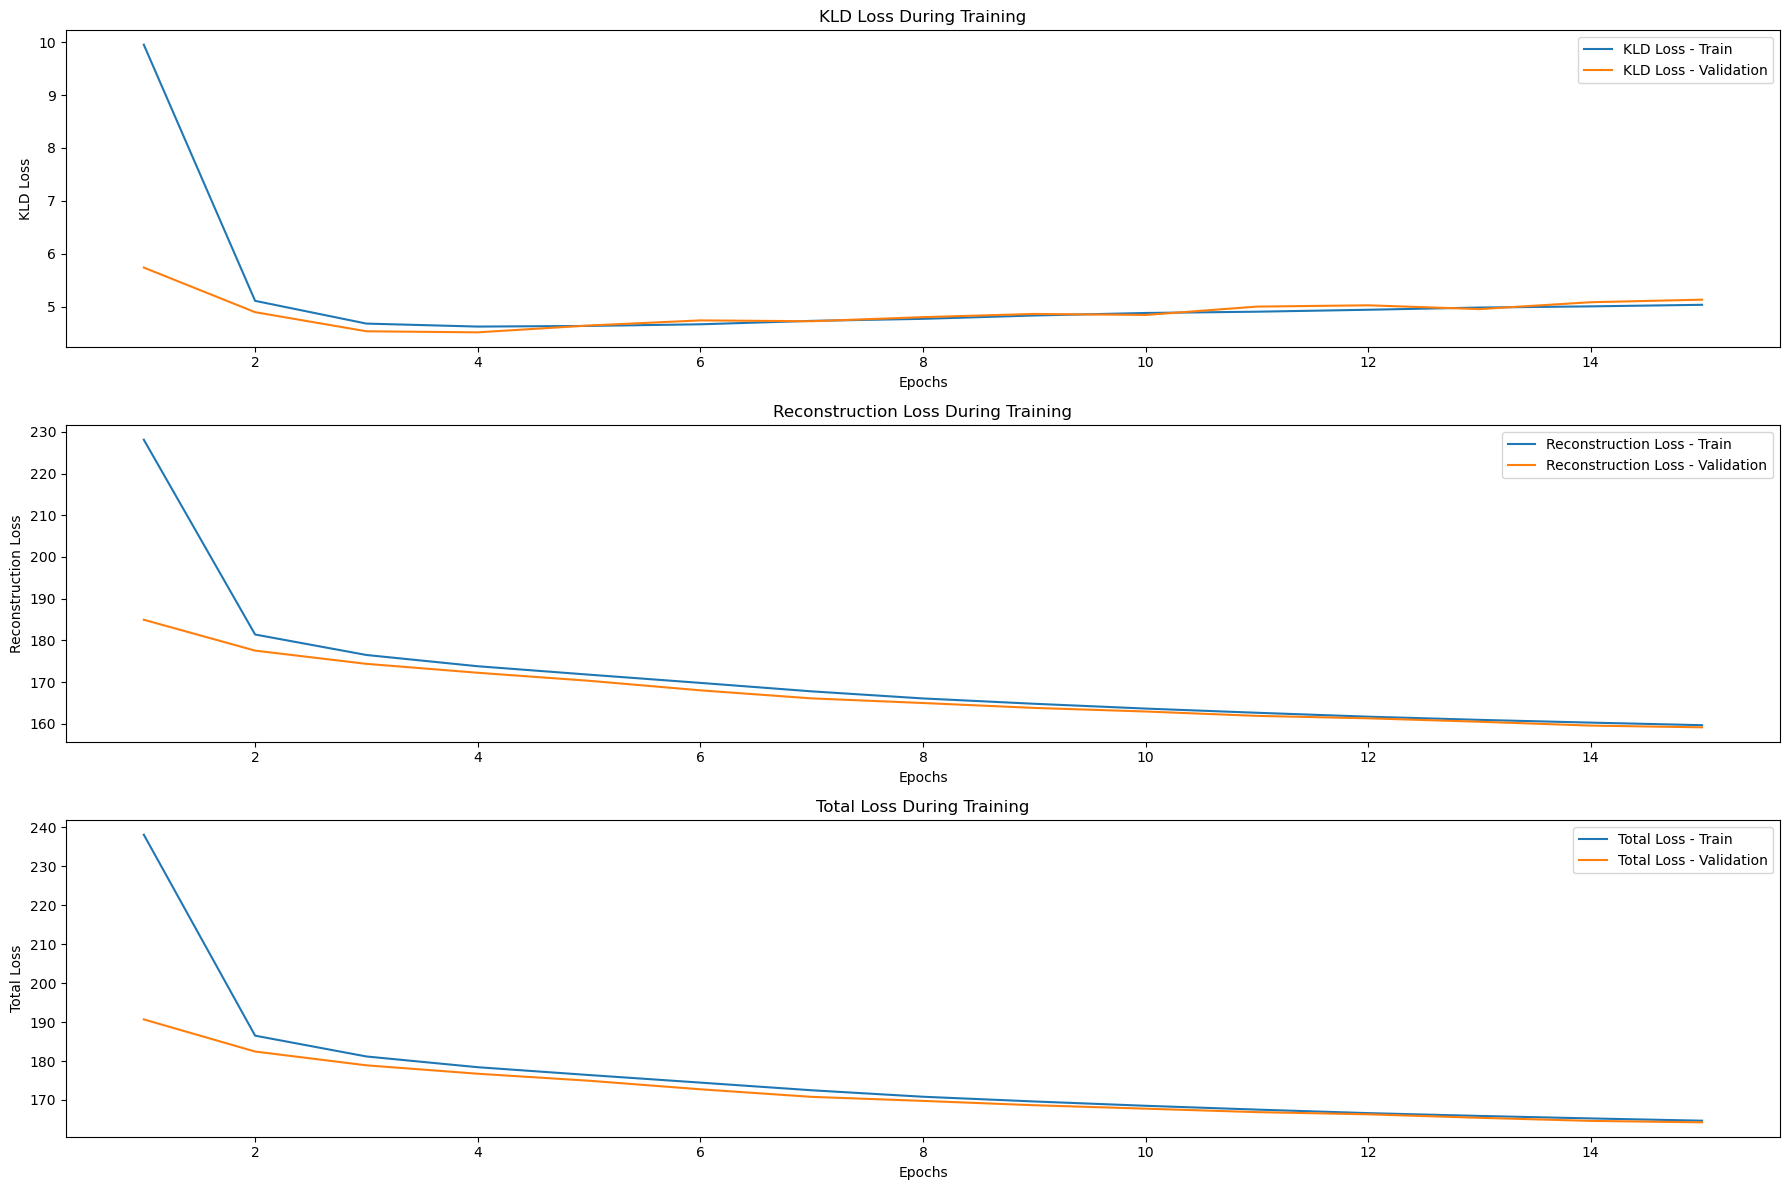

In [20]:
plot_training_history(gaussian_vae_trainer_init.history)

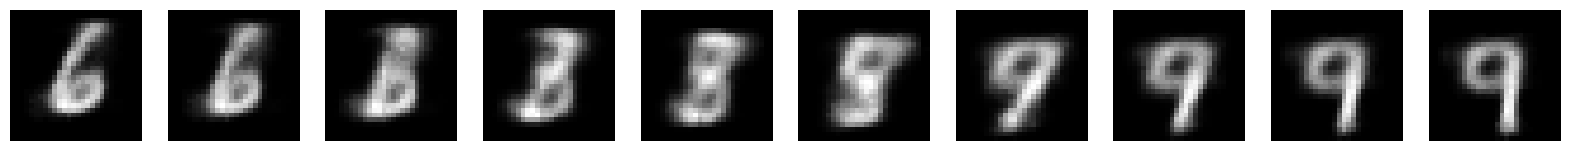

In [28]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,model=gaussian_vae_init)

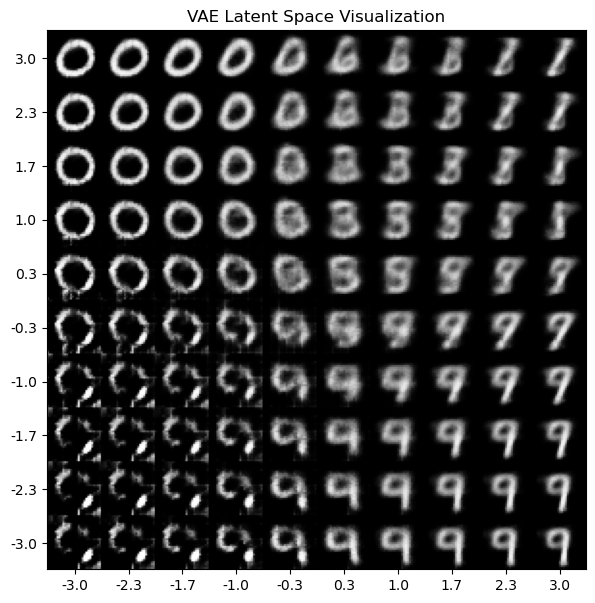

In [29]:
plot_latent_space(gaussian_vae_init,scale=3)

In [30]:
save(gaussian_vae_init,gaussian_vae_trainer_init,'models/gaussian(1,2)_improvements/kaiming_init.pt')

Even though the kld loss did start increasing after epoch five, the generations did improve after kaiming intialisation.

## <a id='toc4_2_'></a>[MSE Loss as Reconstruction Loss](#toc0_)

I have used BCE Loss as the reconstruction loss uptill now for training the vae. Will try mse loss now with kaiming initialisation.

In [40]:
torch.manual_seed(MANUAL_SEED)
gaussian_vae_mse = NormalVAE(LATENT_DIM,1,2)
gaussian_optimizer_mse = torch.optim.Adam(gaussian_vae_mse.parameters(),lr=LEARNING_RATE)

initialize_weights(gaussian_vae_mse)

reconstruction_loss_fn_mse = nn.MSELoss(reduction='sum')

In [41]:
gaussian_vae_trainer_mse = VAETrainer(
    model=gaussian_vae_mse,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=gaussian_optimizer_mse,
    reconstruction_loss_fn=reconstruction_loss_fn_mse,
    device=DEVICE
)

In [42]:
gaussian_vae_trainer_mse.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:29<00:00, 31.84batch/s, kld_loss=92.5, loss=1.57e+3, recon_loss=1.48e+3]


Epoch 1 Training - Total Loss: 65.6258, KLD Loss: 4.0689, Recon Loss: 61.5569


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 79.89batch/s, kld_loss=44.2, recon_loss=803]   


Epoch 1 Evaluation - Total Loss: 49.9380, KLD Loss: 2.7045, Recon Loss: 47.2336


Epoch 2/15: 100%|██████████| 938/938 [00:29<00:00, 31.35batch/s, kld_loss=89, loss=1.56e+3, recon_loss=1.47e+3] 


Epoch 2 Training - Total Loss: 48.7596, KLD Loss: 2.7774, Recon Loss: 45.9821


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 73.68batch/s, kld_loss=44, recon_loss=771]     


Epoch 2 Evaluation - Total Loss: 47.9952, KLD Loss: 2.6958, Recon Loss: 45.2994


Epoch 3/15: 100%|██████████| 938/938 [00:34<00:00, 27.01batch/s, kld_loss=92, loss=1.36e+3, recon_loss=1.27e+3] 


Epoch 3 Training - Total Loss: 47.5857, KLD Loss: 2.7790, Recon Loss: 44.8067


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.72batch/s, kld_loss=45.2, recon_loss=745]   


Epoch 3 Evaluation - Total Loss: 47.0976, KLD Loss: 2.7657, Recon Loss: 44.3319


Epoch 4/15: 100%|██████████| 938/938 [00:41<00:00, 22.56batch/s, kld_loss=91.1, loss=1.42e+3, recon_loss=1.33e+3]


Epoch 4 Training - Total Loss: 46.9077, KLD Loss: 2.8466, Recon Loss: 44.0610


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 52.19batch/s, kld_loss=48, recon_loss=738]     


Epoch 4 Evaluation - Total Loss: 46.4606, KLD Loss: 2.8884, Recon Loss: 43.5723


Epoch 5/15: 100%|██████████| 938/938 [00:37<00:00, 24.80batch/s, kld_loss=95.6, loss=1.58e+3, recon_loss=1.48e+3]


Epoch 5 Training - Total Loss: 46.2626, KLD Loss: 2.9066, Recon Loss: 43.3560


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.11batch/s, kld_loss=50.1, recon_loss=715]   


Epoch 5 Evaluation - Total Loss: 45.6663, KLD Loss: 2.9307, Recon Loss: 42.7356


Epoch 6/15: 100%|██████████| 938/938 [00:36<00:00, 25.92batch/s, kld_loss=104, loss=1.45e+3, recon_loss=1.35e+3]


Epoch 6 Training - Total Loss: 45.5353, KLD Loss: 2.9638, Recon Loss: 42.5715


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 67.79batch/s, kld_loss=54.3, recon_loss=686]   


Epoch 6 Evaluation - Total Loss: 44.8973, KLD Loss: 3.1353, Recon Loss: 41.7620


Epoch 7/15: 100%|██████████| 938/938 [00:33<00:00, 27.65batch/s, kld_loss=99.5, loss=1.59e+3, recon_loss=1.49e+3]


Epoch 7 Training - Total Loss: 44.9087, KLD Loss: 3.0500, Recon Loss: 41.8587


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 45.32batch/s, kld_loss=53.6, recon_loss=686]   


Epoch 7 Evaluation - Total Loss: 44.3368, KLD Loss: 3.0795, Recon Loss: 41.2572


Epoch 8/15: 100%|██████████| 938/938 [00:28<00:00, 33.39batch/s, kld_loss=110, loss=1.24e+3, recon_loss=1.13e+3]


Epoch 8 Training - Total Loss: 44.3997, KLD Loss: 3.0783, Recon Loss: 41.3214


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 82.05batch/s, kld_loss=54.5, recon_loss=674]   


Epoch 8 Evaluation - Total Loss: 44.0525, KLD Loss: 3.1225, Recon Loss: 40.9300


Epoch 9/15: 100%|██████████| 938/938 [00:28<00:00, 33.06batch/s, kld_loss=102, loss=1.46e+3, recon_loss=1.35e+3]


Epoch 9 Training - Total Loss: 44.0122, KLD Loss: 3.1266, Recon Loss: 40.8856


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.47batch/s, kld_loss=54.8, recon_loss=654]   


Epoch 9 Evaluation - Total Loss: 43.5190, KLD Loss: 3.1657, Recon Loss: 40.3533


Epoch 10/15: 100%|██████████| 938/938 [00:29<00:00, 31.38batch/s, kld_loss=101, loss=1.47e+3, recon_loss=1.37e+3]


Epoch 10 Training - Total Loss: 43.5965, KLD Loss: 3.1693, Recon Loss: 40.4272


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.33batch/s, kld_loss=54.9, recon_loss=654]   


Epoch 10 Evaluation - Total Loss: 43.2075, KLD Loss: 3.1986, Recon Loss: 40.0089


Epoch 11/15: 100%|██████████| 938/938 [00:28<00:00, 32.64batch/s, kld_loss=102, loss=1.49e+3, recon_loss=1.39e+3]


Epoch 11 Training - Total Loss: 43.1724, KLD Loss: 3.2350, Recon Loss: 39.9374


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.91batch/s, kld_loss=55.6, recon_loss=642]   


Epoch 11 Evaluation - Total Loss: 42.8405, KLD Loss: 3.3267, Recon Loss: 39.5138


Epoch 12/15: 100%|██████████| 938/938 [00:28<00:00, 32.98batch/s, kld_loss=96.9, loss=1.5e+3, recon_loss=1.4e+3] 


Epoch 12 Training - Total Loss: 42.8246, KLD Loss: 3.3187, Recon Loss: 39.5059


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 71.34batch/s, kld_loss=55.5, recon_loss=635]   


Epoch 12 Evaluation - Total Loss: 42.4974, KLD Loss: 3.3616, Recon Loss: 39.1359


Epoch 13/15: 100%|██████████| 938/938 [00:29<00:00, 32.34batch/s, kld_loss=104, loss=1.47e+3, recon_loss=1.37e+3]


Epoch 13 Training - Total Loss: 42.4978, KLD Loss: 3.3741, Recon Loss: 39.1237


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 74.92batch/s, kld_loss=53.5, recon_loss=629]   


Epoch 13 Evaluation - Total Loss: 42.3231, KLD Loss: 3.3021, Recon Loss: 39.0210


Epoch 14/15: 100%|██████████| 938/938 [00:28<00:00, 32.62batch/s, kld_loss=115, loss=1.28e+3, recon_loss=1.17e+3]


Epoch 14 Training - Total Loss: 42.2504, KLD Loss: 3.4291, Recon Loss: 38.8213


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.63batch/s, kld_loss=56.8, recon_loss=627]   


Epoch 14 Evaluation - Total Loss: 41.9721, KLD Loss: 3.5023, Recon Loss: 38.4698


Epoch 15/15: 100%|██████████| 938/938 [00:32<00:00, 28.57batch/s, kld_loss=110, loss=1.39e+3, recon_loss=1.28e+3]


Epoch 15 Training - Total Loss: 42.0436, KLD Loss: 3.4849, Recon Loss: 38.5587


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 77.19batch/s, kld_loss=56.6, recon_loss=635]   


Epoch 15 Evaluation - Total Loss: 41.7798, KLD Loss: 3.5264, Recon Loss: 38.2533


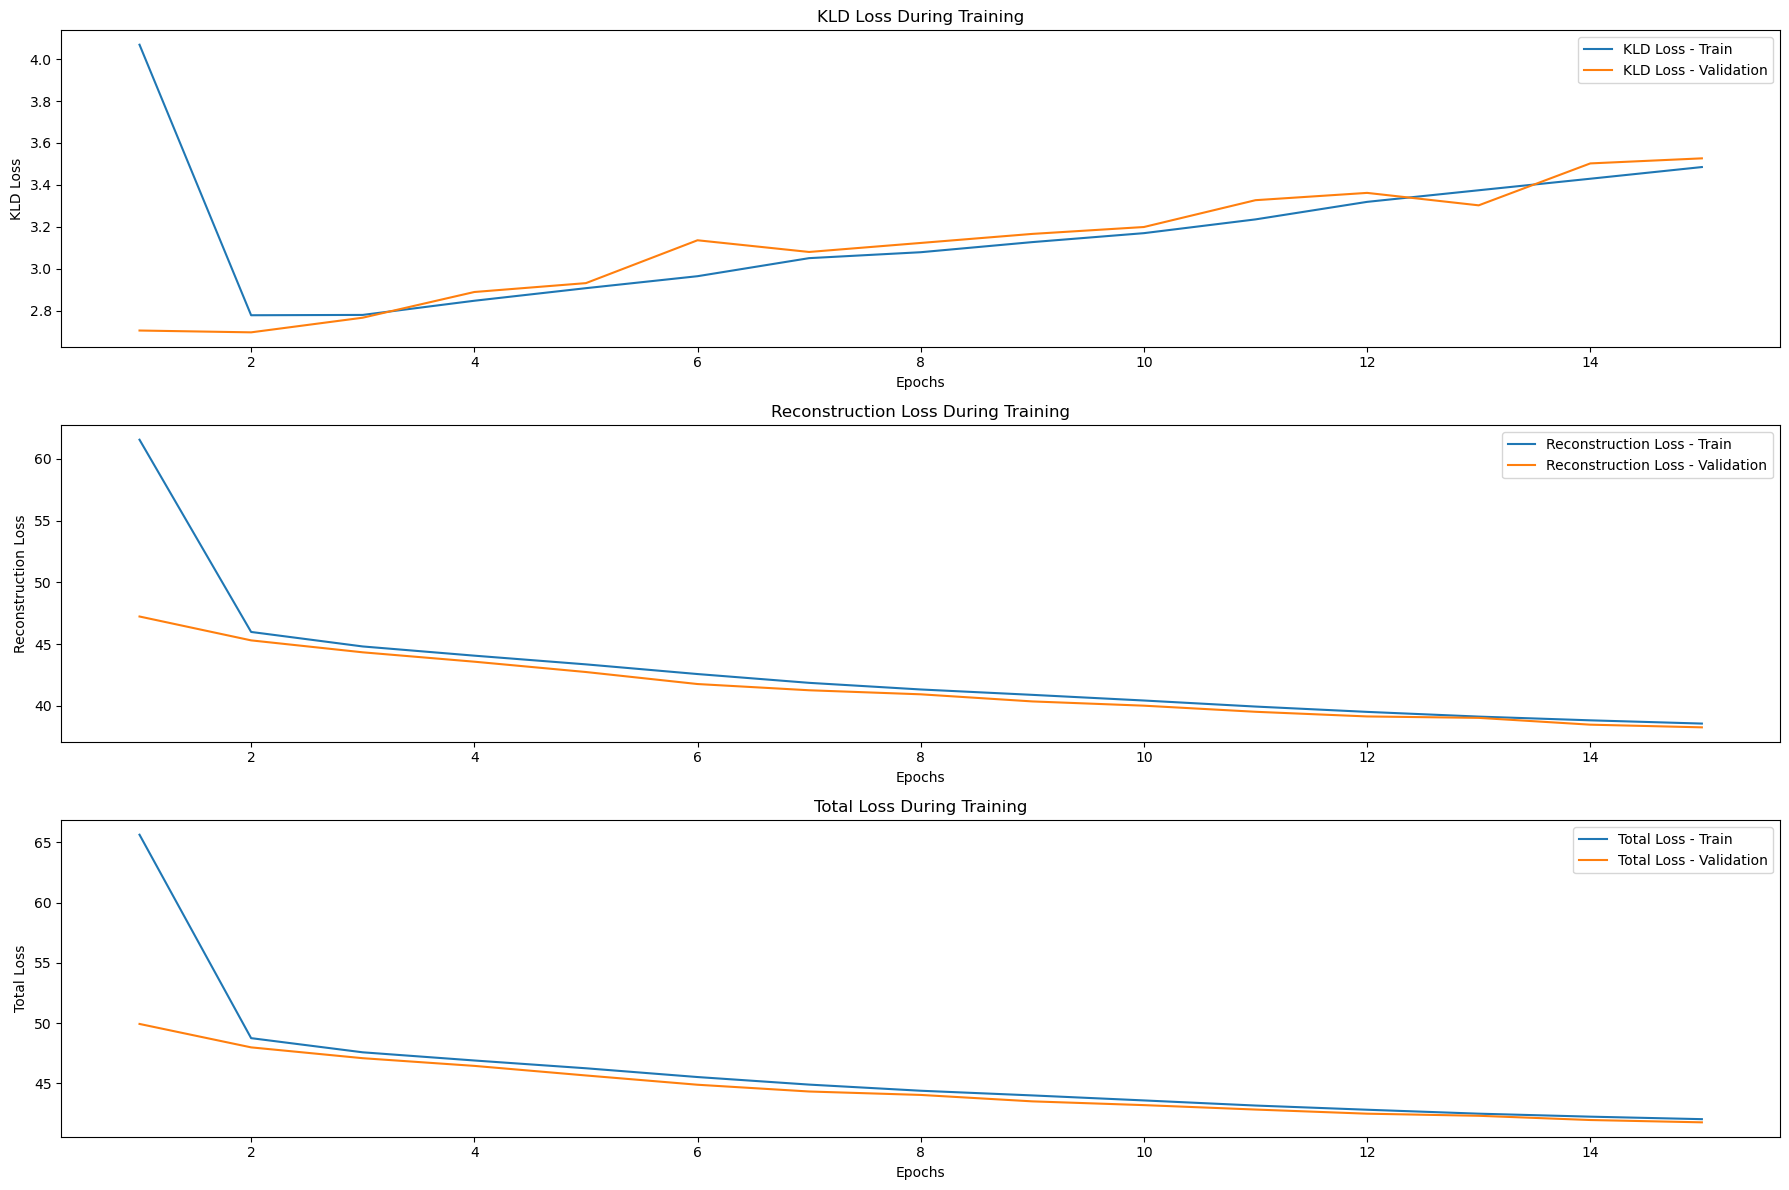

In [43]:
plot_training_history(gaussian_vae_trainer_mse.history)

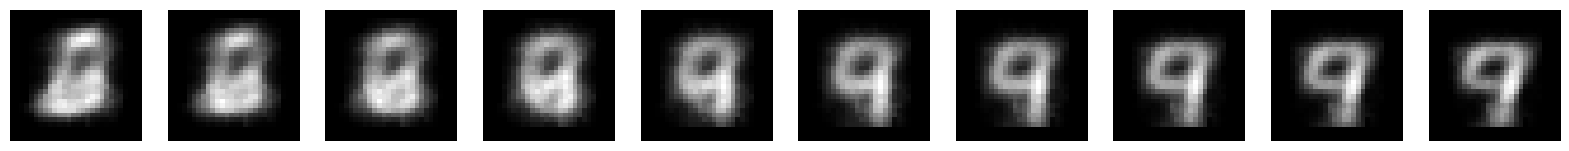

In [46]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,model=gaussian_vae_mse)

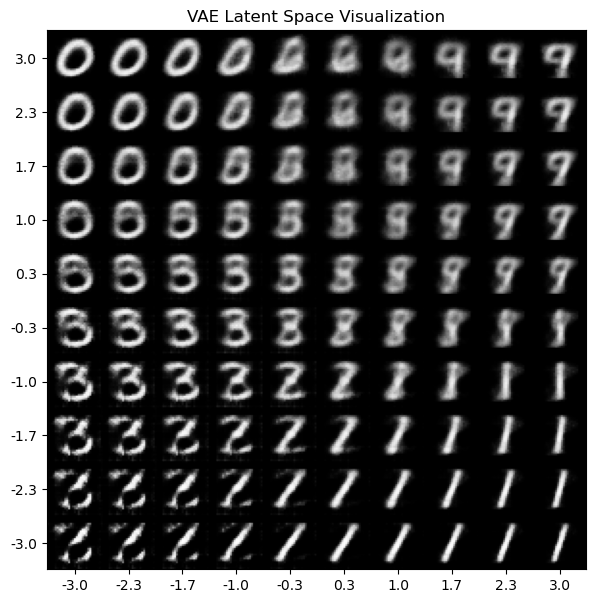

In [47]:
plot_latent_space(gaussian_vae_mse,scale=3)

In [48]:
save(gaussian_vae_mse,gaussian_vae_trainer_mse,'models/gaussian(1,2)_improvements/mse_kaiming_init.pt')

## <a id='toc4_3_'></a>[MAE Loss as Reconstruction Loss](#toc0_)

In [49]:
torch.manual_seed(MANUAL_SEED)
gaussian_vae_mae = NormalVAE(LATENT_DIM,1,2)
gaussian_optimizer_mae = torch.optim.Adam(gaussian_vae_mae.parameters(),lr=LEARNING_RATE)

initialize_weights(gaussian_vae_mae)

reconstruction_loss_fn_mae = nn.L1Loss(reduction='sum')

In [50]:
gaussian_vae_trainer_mae = VAETrainer(
    model=gaussian_vae_mae,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=gaussian_optimizer_mae,
    reconstruction_loss_fn=reconstruction_loss_fn_mae,
    device=DEVICE
)

In [51]:
gaussian_vae_trainer_mae.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:30<00:00, 30.58batch/s, kld_loss=119, loss=3.06e+3, recon_loss=2.94e+3]    


Epoch 1 Training - Total Loss: 132.1611, KLD Loss: 7.8339, Recon Loss: 124.3272


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 69.74batch/s, kld_loss=59.8, recon_loss=1.63e+3]


Epoch 1 Evaluation - Total Loss: 95.8991, KLD Loss: 3.7167, Recon Loss: 92.1824


Epoch 2/15: 100%|██████████| 938/938 [00:29<00:00, 31.66batch/s, kld_loss=98.1, loss=2.97e+3, recon_loss=2.87e+3]


Epoch 2 Training - Total Loss: 91.8024, KLD Loss: 3.3361, Recon Loss: 88.4663


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.76batch/s, kld_loss=48.4, recon_loss=1.51e+3]


Epoch 2 Evaluation - Total Loss: 89.8165, KLD Loss: 2.9387, Recon Loss: 86.8778


Epoch 3/15: 100%|██████████| 938/938 [00:29<00:00, 32.29batch/s, kld_loss=97.2, loss=2.5e+3, recon_loss=2.4e+3] 


Epoch 3 Training - Total Loss: 88.5182, KLD Loss: 3.1090, Recon Loss: 85.4093


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.54batch/s, kld_loss=48.3, recon_loss=1.46e+3]


Epoch 3 Evaluation - Total Loss: 87.9949, KLD Loss: 3.0061, Recon Loss: 84.9888


Epoch 4/15: 100%|██████████| 938/938 [00:28<00:00, 32.62batch/s, kld_loss=98.8, loss=2.7e+3, recon_loss=2.6e+3] 


Epoch 4 Training - Total Loss: 87.2360, KLD Loss: 3.1053, Recon Loss: 84.1307


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.74batch/s, kld_loss=47.6, recon_loss=1.47e+3]


Epoch 4 Evaluation - Total Loss: 86.8575, KLD Loss: 3.0130, Recon Loss: 83.8445


Epoch 5/15: 100%|██████████| 938/938 [00:28<00:00, 33.08batch/s, kld_loss=98.1, loss=2.95e+3, recon_loss=2.86e+3]


Epoch 5 Training - Total Loss: 86.2711, KLD Loss: 3.1477, Recon Loss: 83.1234


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.48batch/s, kld_loss=50.4, recon_loss=1.45e+3]


Epoch 5 Evaluation - Total Loss: 85.8380, KLD Loss: 3.1787, Recon Loss: 82.6594


Epoch 6/15: 100%|██████████| 938/938 [00:29<00:00, 32.29batch/s, kld_loss=108, loss=2.79e+3, recon_loss=2.68e+3]


Epoch 6 Training - Total Loss: 85.4132, KLD Loss: 3.1892, Recon Loss: 82.2240


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 81.72batch/s, kld_loss=54.8, recon_loss=1.43e+3]


Epoch 6 Evaluation - Total Loss: 84.9638, KLD Loss: 3.4040, Recon Loss: 81.5598


Epoch 7/15: 100%|██████████| 938/938 [00:27<00:00, 34.26batch/s, kld_loss=107, loss=2.87e+3, recon_loss=2.76e+3]


Epoch 7 Training - Total Loss: 84.5808, KLD Loss: 3.2347, Recon Loss: 81.3461


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 82.44batch/s, kld_loss=52.8, recon_loss=1.39e+3]


Epoch 7 Evaluation - Total Loss: 84.1214, KLD Loss: 3.2795, Recon Loss: 80.8419


Epoch 8/15: 100%|██████████| 938/938 [00:28<00:00, 32.80batch/s, kld_loss=120, loss=2.34e+3, recon_loss=2.22e+3]


Epoch 8 Training - Total Loss: 83.6823, KLD Loss: 3.2832, Recon Loss: 80.3990


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.03batch/s, kld_loss=53.5, recon_loss=1.38e+3]


Epoch 8 Evaluation - Total Loss: 83.3281, KLD Loss: 3.3215, Recon Loss: 80.0065


Epoch 9/15: 100%|██████████| 938/938 [00:29<00:00, 32.22batch/s, kld_loss=114, loss=2.69e+3, recon_loss=2.58e+3]


Epoch 9 Training - Total Loss: 82.9427, KLD Loss: 3.3694, Recon Loss: 79.5733


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.45batch/s, kld_loss=56.6, recon_loss=1.37e+3]


Epoch 9 Evaluation - Total Loss: 82.5842, KLD Loss: 3.4377, Recon Loss: 79.1465


Epoch 10/15: 100%|██████████| 938/938 [00:29<00:00, 31.61batch/s, kld_loss=104, loss=2.79e+3, recon_loss=2.69e+3]


Epoch 10 Training - Total Loss: 82.3961, KLD Loss: 3.3953, Recon Loss: 79.0008


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 70.33batch/s, kld_loss=55.1, recon_loss=1.38e+3]


Epoch 10 Evaluation - Total Loss: 82.1617, KLD Loss: 3.3936, Recon Loss: 78.7681


Epoch 11/15: 100%|██████████| 938/938 [00:28<00:00, 33.10batch/s, kld_loss=108, loss=2.8e+3, recon_loss=2.7e+3]  


Epoch 11 Training - Total Loss: 82.0479, KLD Loss: 3.4217, Recon Loss: 78.6262


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 81.20batch/s, kld_loss=56.6, recon_loss=1.33e+3]


Epoch 11 Evaluation - Total Loss: 81.9005, KLD Loss: 3.5146, Recon Loss: 78.3859


Epoch 12/15: 100%|██████████| 938/938 [00:31<00:00, 30.17batch/s, kld_loss=97.9, loss=2.72e+3, recon_loss=2.62e+3]


Epoch 12 Training - Total Loss: 81.7820, KLD Loss: 3.4526, Recon Loss: 78.3294


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 79.67batch/s, kld_loss=55.1, recon_loss=1.35e+3]


Epoch 12 Evaluation - Total Loss: 81.6186, KLD Loss: 3.4494, Recon Loss: 78.1692


Epoch 13/15: 100%|██████████| 938/938 [00:27<00:00, 34.13batch/s, kld_loss=107, loss=2.77e+3, recon_loss=2.66e+3]


Epoch 13 Training - Total Loss: 81.6051, KLD Loss: 3.4734, Recon Loss: 78.1317


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 81.99batch/s, kld_loss=54.3, recon_loss=1.34e+3]


Epoch 13 Evaluation - Total Loss: 81.4632, KLD Loss: 3.4166, Recon Loss: 78.0467


Epoch 14/15: 100%|██████████| 938/938 [00:28<00:00, 33.46batch/s, kld_loss=114, loss=2.58e+3, recon_loss=2.46e+3]


Epoch 14 Training - Total Loss: 81.4065, KLD Loss: 3.4700, Recon Loss: 77.9364


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 80.97batch/s, kld_loss=56.1, recon_loss=1.35e+3]


Epoch 14 Evaluation - Total Loss: 81.3367, KLD Loss: 3.5266, Recon Loss: 77.8101


Epoch 15/15: 100%|██████████| 938/938 [00:27<00:00, 34.15batch/s, kld_loss=108, loss=2.7e+3, recon_loss=2.59e+3] 


Epoch 15 Training - Total Loss: 81.2593, KLD Loss: 3.4849, Recon Loss: 77.7745


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 78.78batch/s, kld_loss=57, recon_loss=1.35e+3] 

Epoch 15 Evaluation - Total Loss: 81.1197, KLD Loss: 3.5798, Recon Loss: 77.5398


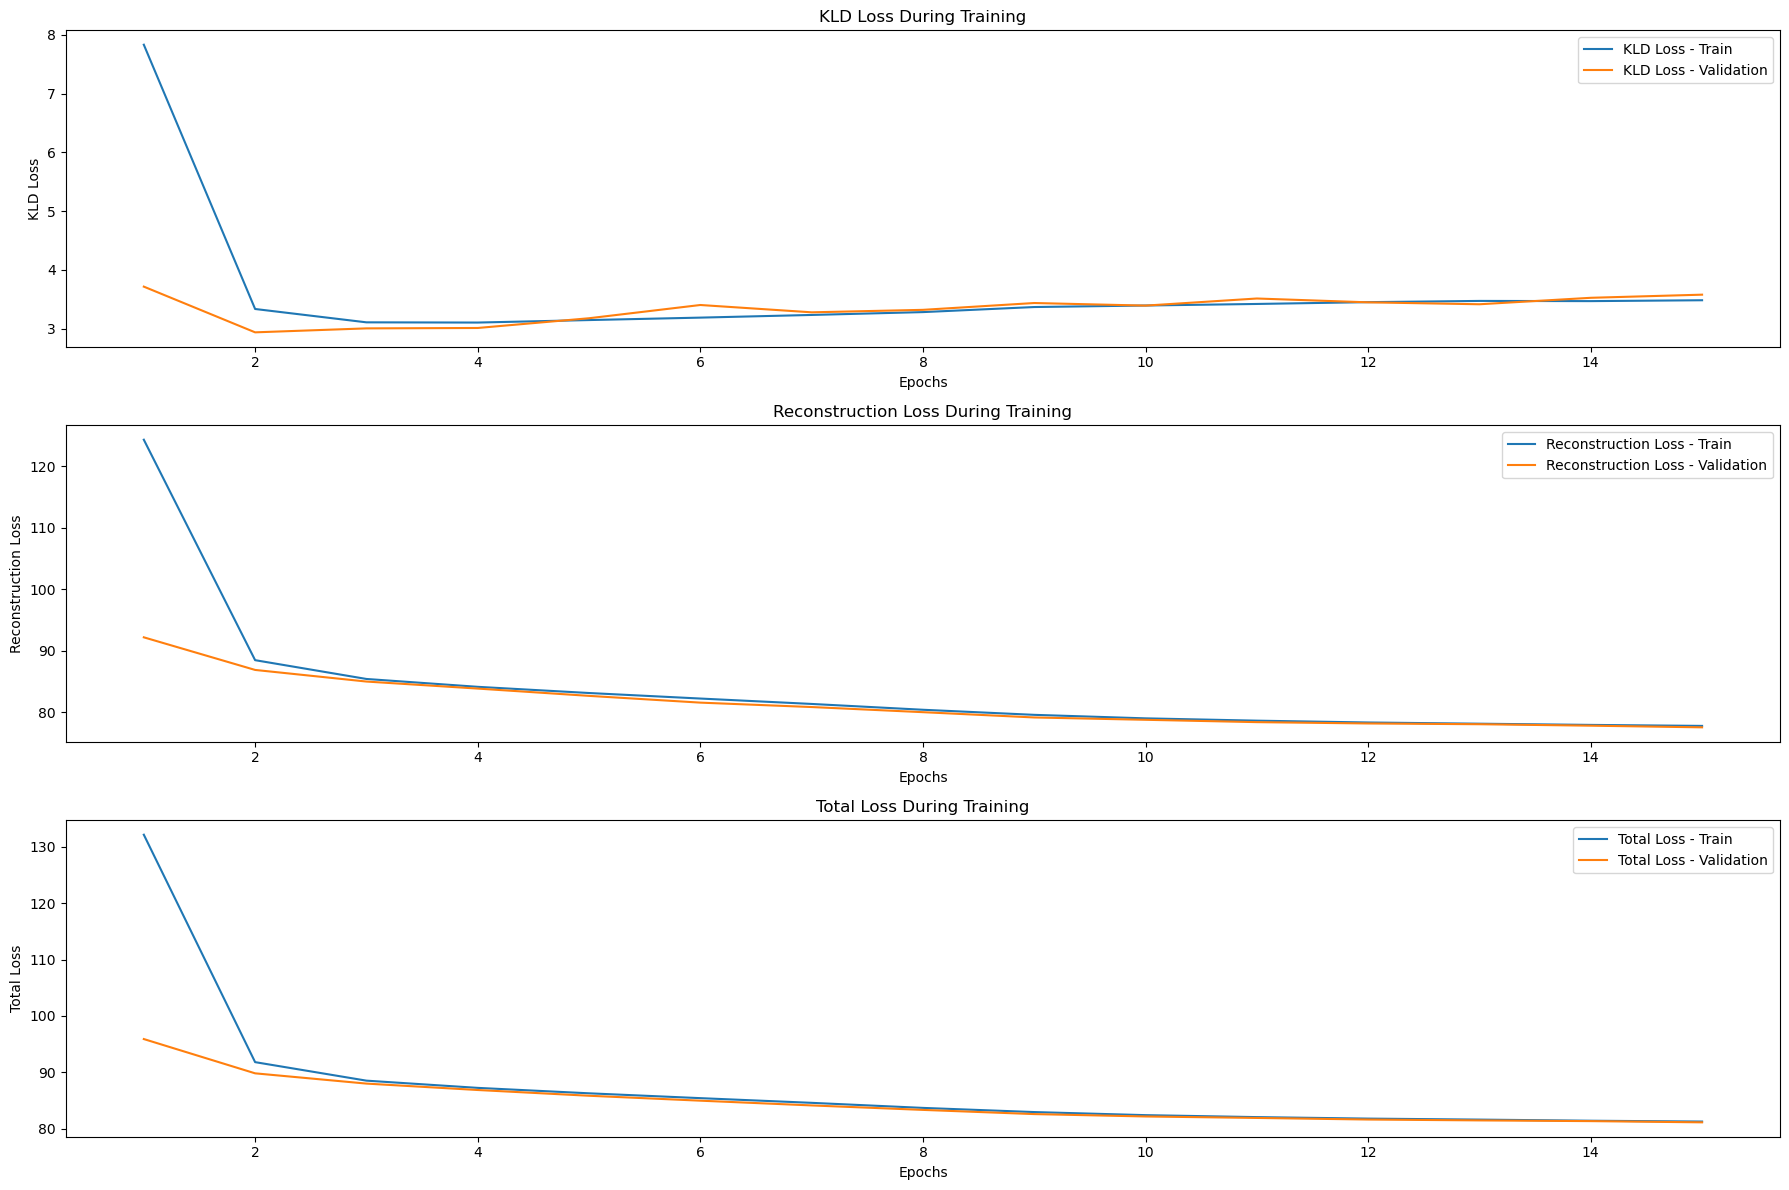

In [52]:
plot_training_history(gaussian_vae_trainer_mae.history)

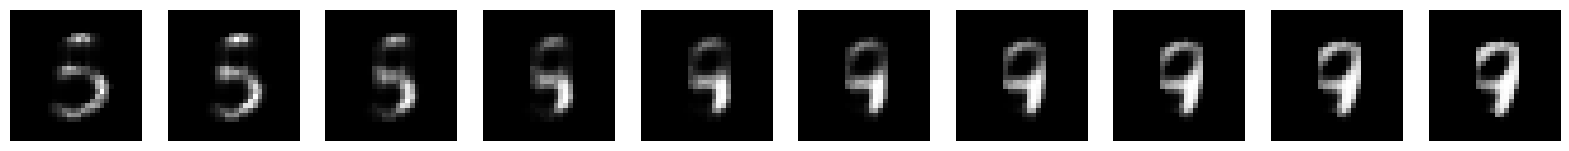

In [53]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,model=gaussian_vae_mae)

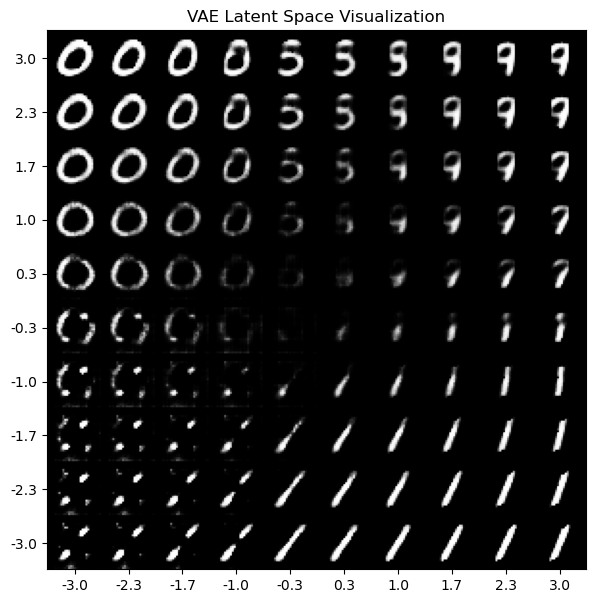

In [54]:
plot_latent_space(gaussian_vae_mae,scale=3)

In [55]:
save(gaussian_vae_mae,gaussian_vae_trainer_mae,'models/gaussian(1,2)_improvements/mae_kaiming_init.pt')

## <a id='toc4_4_'></a>[Perceptual Loss as Reconstruction Loss](#toc0_)

I trained a classifier on MNIST dataset. 

In [7]:
from models import ClassifierMNIST
from losses import PerceptualLoss
from losses import WeightedPerceptual

classifier = ClassifierMNIST()

classifier.load_state_dict(torch.load('models/mnist_classifier.pt'))

<All keys matched successfully>

In [25]:
classifier.features

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU(inplace=True)
)

In [57]:
torch.manual_seed(MANUAL_SEED)
gaussian_vae_perceptual = NormalVAE(LATENT_DIM,1,2)
gaussian_optimizer_perceptual = torch.optim.Adam(gaussian_vae_perceptual.parameters(),lr=LEARNING_RATE)

initialize_weights(gaussian_vae_perceptual)

# I used second and 4th relu
selected_layers = (3,7)
reconstruction_loss_fn_perceptual = PerceptualLoss(classifier.features,
                                                   selected_layers,
                                                   DEVICE,
                                                   reduction='sum')

In [58]:
gaussian_vae_trainer_perceptual = VAETrainer(
    model=gaussian_vae_perceptual,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=gaussian_optimizer_perceptual,
    reconstruction_loss_fn=reconstruction_loss_fn_perceptual,
    device=DEVICE
)

In [59]:
gaussian_vae_trainer_perceptual.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:43<00:00, 21.75batch/s, kld_loss=4.46e+3, loss=4.3e+5, recon_loss=4.26e+5] 


Epoch 1 Training - Total Loss: 17461.7188, KLD Loss: 102.3663, Recon Loss: 17359.3525


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 39.45batch/s, kld_loss=2.02e+3, recon_loss=2.49e+5]


Epoch 1 Evaluation - Total Loss: 15026.5801, KLD Loss: 121.5892, Recon Loss: 14904.9909


Epoch 2/15: 100%|██████████| 938/938 [00:40<00:00, 23.11batch/s, kld_loss=3.21e+3, loss=4.27e+5, recon_loss=4.23e+5]


Epoch 2 Training - Total Loss: 14651.2470, KLD Loss: 102.8470, Recon Loss: 14548.4000


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 48.11batch/s, kld_loss=1.46e+3, recon_loss=2.32e+5]


Epoch 2 Evaluation - Total Loss: 14240.6264, KLD Loss: 93.3156, Recon Loss: 14147.3108


Epoch 3/15: 100%|██████████| 938/938 [00:43<00:00, 21.37batch/s, kld_loss=1.71e+3, loss=4.06e+5, recon_loss=4.04e+5]


Epoch 3 Training - Total Loss: 14147.5738, KLD Loss: 82.5850, Recon Loss: 14064.9887


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 33.32batch/s, kld_loss=1.16e+3, recon_loss=2.28e+5]


Epoch 3 Evaluation - Total Loss: 13889.7740, KLD Loss: 77.0740, Recon Loss: 13812.7000


Epoch 4/15: 100%|██████████| 938/938 [00:39<00:00, 23.81batch/s, kld_loss=1.94e+3, loss=4.32e+5, recon_loss=4.3e+5] 


Epoch 4 Training - Total Loss: 13856.1733, KLD Loss: 74.3942, Recon Loss: 13781.7792


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 45.85batch/s, kld_loss=1.11e+3, recon_loss=2.26e+5]


Epoch 4 Evaluation - Total Loss: 13616.9207, KLD Loss: 74.5184, Recon Loss: 13542.4023


Epoch 5/15: 100%|██████████| 938/938 [00:37<00:00, 24.75batch/s, kld_loss=2.29e+3, loss=4.59e+5, recon_loss=4.57e+5]


Epoch 5 Training - Total Loss: 13633.4808, KLD Loss: 71.1620, Recon Loss: 13562.3188


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 48.24batch/s, kld_loss=1.03e+3, recon_loss=2.23e+5]


Epoch 5 Evaluation - Total Loss: 13433.1356, KLD Loss: 69.7705, Recon Loss: 13363.3651


Epoch 6/15: 100%|██████████| 938/938 [00:37<00:00, 24.83batch/s, kld_loss=2.45e+3, loss=3.76e+5, recon_loss=3.74e+5]


Epoch 6 Training - Total Loss: 13470.0098, KLD Loss: 68.0671, Recon Loss: 13401.9427


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 50.22batch/s, kld_loss=1.01e+3, recon_loss=2.19e+5]


Epoch 6 Evaluation - Total Loss: 13308.1539, KLD Loss: 67.9530, Recon Loss: 13240.2009


Epoch 7/15: 100%|██████████| 938/938 [00:37<00:00, 24.95batch/s, kld_loss=2.65e+3, loss=4.25e+5, recon_loss=4.23e+5]


Epoch 7 Training - Total Loss: 13336.0629, KLD Loss: 67.3622, Recon Loss: 13268.7007


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 48.09batch/s, kld_loss=996, recon_loss=2.18e+5]    


Epoch 7 Evaluation - Total Loss: 13155.9611, KLD Loss: 67.2147, Recon Loss: 13088.7464


Epoch 8/15: 100%|██████████| 938/938 [00:38<00:00, 24.57batch/s, kld_loss=2.85e+3, loss=3.75e+5, recon_loss=3.72e+5]


Epoch 8 Training - Total Loss: 13217.2606, KLD Loss: 66.3533, Recon Loss: 13150.9073


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 48.63batch/s, kld_loss=980, recon_loss=2.12e+5]    


Epoch 8 Evaluation - Total Loss: 13102.2406, KLD Loss: 67.2312, Recon Loss: 13035.0094


Epoch 9/15: 100%|██████████| 938/938 [00:38<00:00, 24.57batch/s, kld_loss=2.39e+3, loss=4.08e+5, recon_loss=4.05e+5]


Epoch 9 Training - Total Loss: 13112.6285, KLD Loss: 65.3203, Recon Loss: 13047.3082


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 48.30batch/s, kld_loss=948, recon_loss=2.12e+5]    


Epoch 9 Evaluation - Total Loss: 13000.5470, KLD Loss: 65.3755, Recon Loss: 12935.1715


Epoch 10/15: 100%|██████████| 938/938 [00:40<00:00, 23.22batch/s, kld_loss=2.23e+3, loss=4.7e+5, recon_loss=4.68e+5] 


Epoch 10 Training - Total Loss: 13022.9302, KLD Loss: 63.8004, Recon Loss: 12959.1297


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 34.21batch/s, kld_loss=945, recon_loss=2.13e+5]    


Epoch 10 Evaluation - Total Loss: 12905.6301, KLD Loss: 65.2725, Recon Loss: 12840.3576


Epoch 11/15: 100%|██████████| 938/938 [00:48<00:00, 19.48batch/s, kld_loss=1.89e+3, loss=4.75e+5, recon_loss=4.73e+5]


Epoch 11 Training - Total Loss: 12944.1152, KLD Loss: 62.5838, Recon Loss: 12881.5315


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 39.23batch/s, kld_loss=908, recon_loss=2.12e+5]    


Epoch 11 Evaluation - Total Loss: 12829.8851, KLD Loss: 62.9878, Recon Loss: 12766.8974


Epoch 12/15: 100%|██████████| 938/938 [00:39<00:00, 23.70batch/s, kld_loss=1.41e+3, loss=4.69e+5, recon_loss=4.68e+5]


Epoch 12 Training - Total Loss: 12873.8926, KLD Loss: 61.0950, Recon Loss: 12812.7977


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 46.41batch/s, kld_loss=891, recon_loss=2.14e+5]    


Epoch 12 Evaluation - Total Loss: 12773.9985, KLD Loss: 61.5609, Recon Loss: 12712.4376


Epoch 13/15: 100%|██████████| 938/938 [00:39<00:00, 23.99batch/s, kld_loss=1.79e+3, loss=4.67e+5, recon_loss=4.65e+5]


Epoch 13 Training - Total Loss: 12810.3919, KLD Loss: 59.2980, Recon Loss: 12751.0939


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 48.94batch/s, kld_loss=884, recon_loss=2.1e+5]     


Epoch 13 Evaluation - Total Loss: 12722.6785, KLD Loss: 60.2551, Recon Loss: 12662.4233


Epoch 14/15: 100%|██████████| 938/938 [00:37<00:00, 24.92batch/s, kld_loss=2.12e+3, loss=3.85e+5, recon_loss=3.83e+5]


Epoch 14 Training - Total Loss: 12752.1923, KLD Loss: 58.3126, Recon Loss: 12693.8797


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 49.31batch/s, kld_loss=835, recon_loss=2.07e+5]    


Epoch 14 Evaluation - Total Loss: 12653.2198, KLD Loss: 58.0676, Recon Loss: 12595.1523


Epoch 15/15: 100%|██████████| 938/938 [00:38<00:00, 24.25batch/s, kld_loss=1.7e+3, loss=4.34e+5, recon_loss=4.32e+5] 


Epoch 15 Training - Total Loss: 12696.9210, KLD Loss: 56.3567, Recon Loss: 12640.5643


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 48.53batch/s, kld_loss=819, recon_loss=2.06e+5]    

Epoch 15 Evaluation - Total Loss: 12611.3677, KLD Loss: 56.7165, Recon Loss: 12554.6512


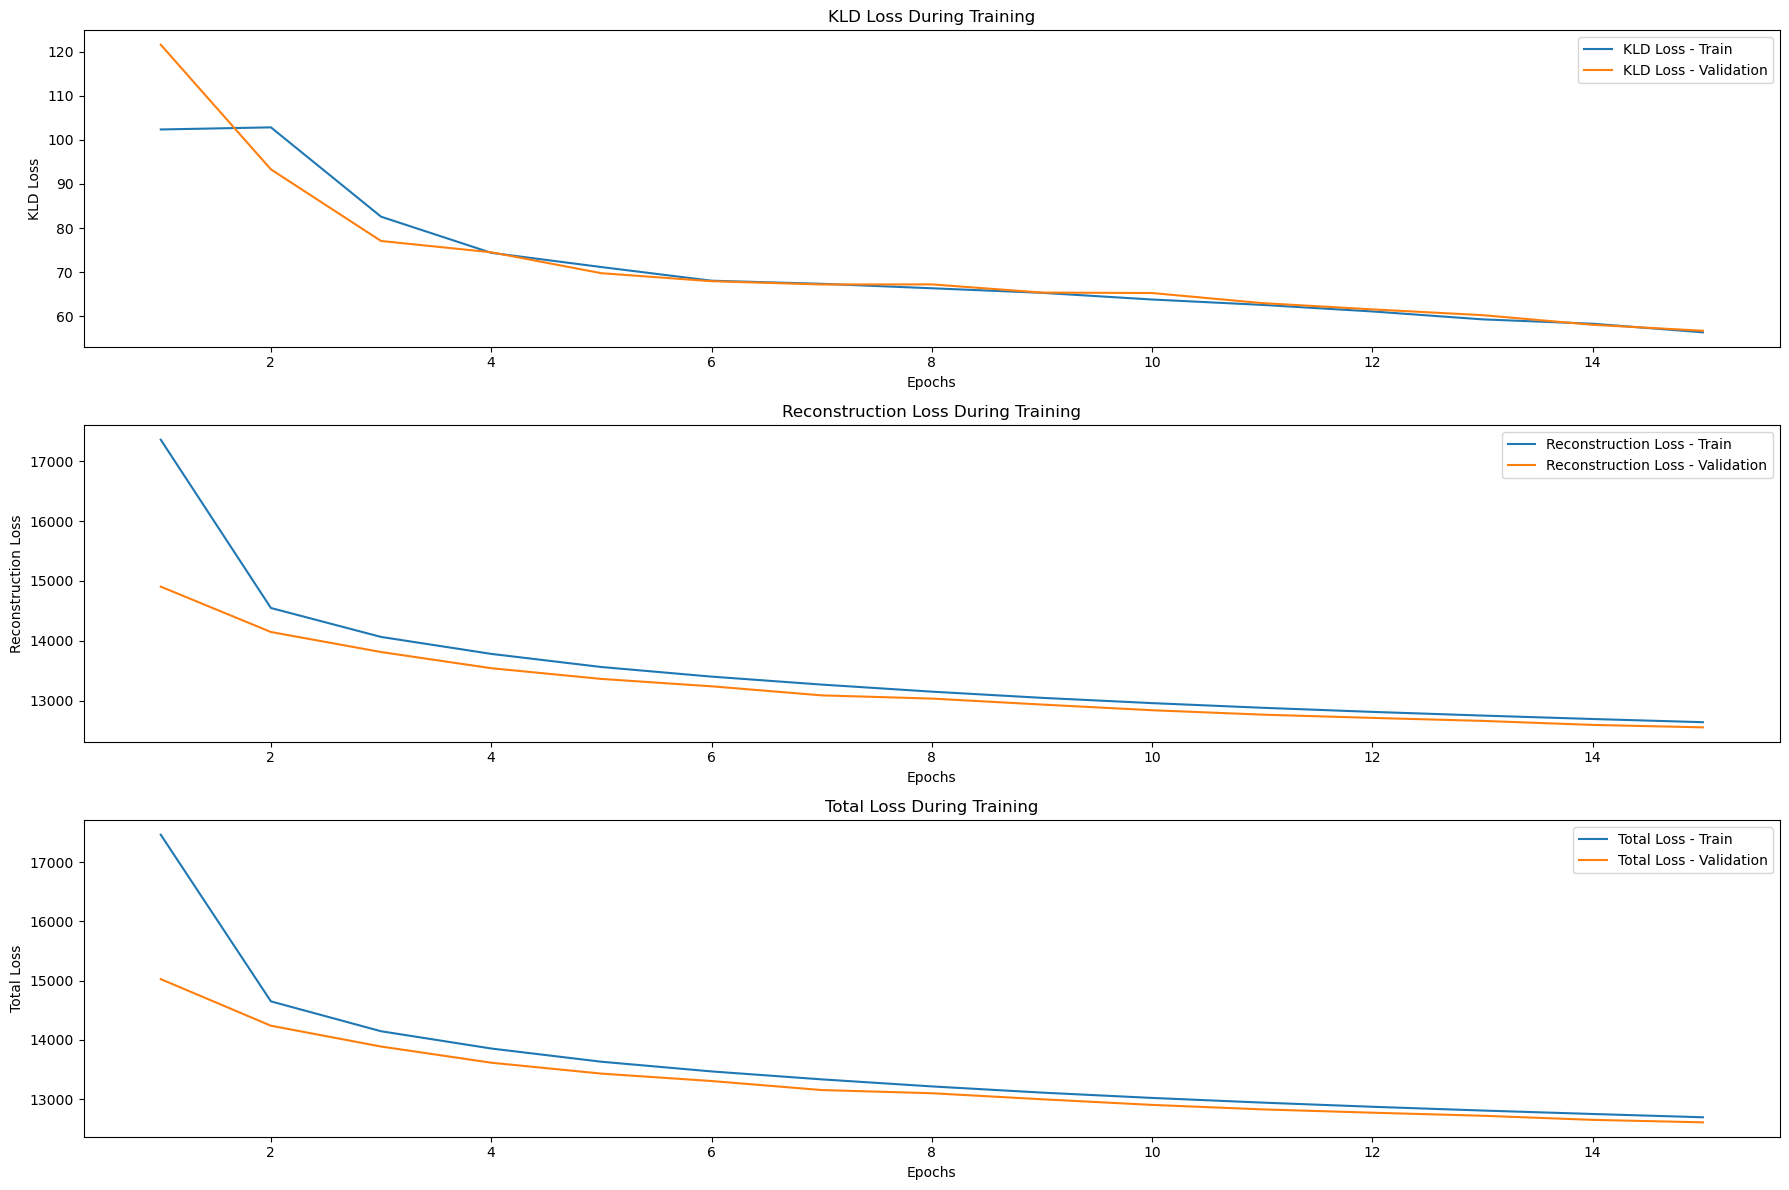

In [60]:
plot_training_history(gaussian_vae_trainer_perceptual.history)

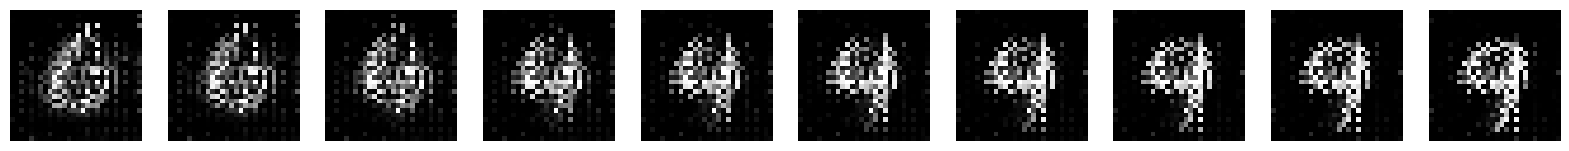

In [61]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,model=gaussian_vae_perceptual)

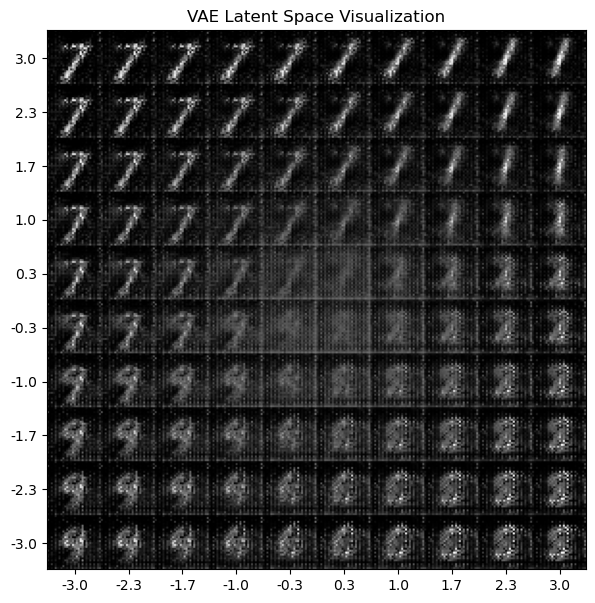

In [62]:
plot_latent_space(gaussian_vae_perceptual,scale=3)

In [63]:
save(gaussian_vae_perceptual,gaussian_vae_trainer_perceptual,'models/gaussian(1,2)_improvements/perceptual_kaiming_init.pt')

## <a id='toc4_5_'></a>[Weighted Perceptual Loss with BCE Loss as Reconstruction Loss](#toc0_)

BCE Loss clearly generated better samples so I am pairing this up with perceptual.

In [49]:
torch.manual_seed(MANUAL_SEED)
gaussian_vae_perceptual_bce = NormalVAE(LATENT_DIM,1,2)
gaussian_optimizer_perceptual_bce = torch.optim.Adam(gaussian_vae_perceptual_bce.parameters(),lr=LEARNING_RATE)

initialize_weights(gaussian_vae_perceptual_bce)

perceptual_weight = 0.01

# I used second and 4th relu
selected_layers = (3,7)
reconstruction_loss_fn_perceptual_bce = WeightedPerceptual(selected_layers,
                                                       classifier.features,
                                                       DEVICE,
                                                       perceptual_weight,
                                                       nn.BCELoss,
                                                       reduction='sum')

In [50]:
gaussian_vae_trainer_perceptual_bce = VAETrainer(
    model=gaussian_vae_perceptual_bce,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=gaussian_optimizer_perceptual_bce,
    reconstruction_loss_fn=reconstruction_loss_fn_perceptual_bce,
    device=DEVICE
)

In [51]:
gaussian_vae_trainer_perceptual_bce.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:38<00:00, 24.63batch/s, kld_loss=319, loss=1.1e+4, recon_loss=1.06e+4]     


Epoch 1 Training - Total Loss: 425.0701, KLD Loss: 14.4485, Recon Loss: 410.6217


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 47.51batch/s, kld_loss=152, recon_loss=5.61e+3]


Epoch 1 Evaluation - Total Loss: 362.3322, KLD Loss: 8.8490, Recon Loss: 353.4832


Epoch 2/15: 100%|██████████| 938/938 [00:39<00:00, 23.99batch/s, kld_loss=255, loss=1.07e+4, recon_loss=1.04e+4]


Epoch 2 Training - Total Loss: 355.0398, KLD Loss: 7.7071, Recon Loss: 347.3327


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 49.24batch/s, kld_loss=129, recon_loss=5416.75]


Epoch 2 Evaluation - Total Loss: 347.9569, KLD Loss: 7.4061, Recon Loss: 340.5508


Epoch 3/15: 100%|██████████| 938/938 [00:37<00:00, 24.93batch/s, kld_loss=214, loss=9.81e+3, recon_loss=9.6e+3] 


Epoch 3 Training - Total Loss: 342.8449, KLD Loss: 7.0499, Recon Loss: 335.7950


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 46.97batch/s, kld_loss=119, recon_loss=5.22e+3]


Epoch 3 Evaluation - Total Loss: 337.8178, KLD Loss: 6.7851, Recon Loss: 331.0328


Epoch 4/15: 100%|██████████| 938/938 [00:40<00:00, 22.93batch/s, kld_loss=202, loss=1.07e+4, recon_loss=1.05e+4]


Epoch 4 Training - Total Loss: 334.0535, KLD Loss: 6.9579, Recon Loss: 327.0956


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 44.73batch/s, kld_loss=123, recon_loss=5.14e+3]


Epoch 4 Evaluation - Total Loss: 329.6296, KLD Loss: 6.9829, Recon Loss: 322.6467


Epoch 5/15: 100%|██████████| 938/938 [00:42<00:00, 22.22batch/s, kld_loss=232, loss=1.14e+4, recon_loss=1.11e+4]


Epoch 5 Training - Total Loss: 327.5988, KLD Loss: 6.8454, Recon Loss: 320.7533


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 46.32batch/s, kld_loss=121, recon_loss=5.08e+3]


Epoch 5 Evaluation - Total Loss: 324.7473, KLD Loss: 6.8512, Recon Loss: 317.8961


Epoch 6/15: 100%|██████████| 938/938 [00:40<00:00, 22.98batch/s, kld_loss=201, loss=1.05e+4, recon_loss=1.03e+4]


Epoch 6 Training - Total Loss: 322.8830, KLD Loss: 6.7808, Recon Loss: 316.1022


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 42.96batch/s, kld_loss=118, recon_loss=4.9e+3] 


Epoch 6 Evaluation - Total Loss: 320.0793, KLD Loss: 6.7295, Recon Loss: 313.3498


Epoch 7/15: 100%|██████████| 938/938 [00:42<00:00, 22.02batch/s, kld_loss=211, loss=1.03e+4, recon_loss=1.01e+4]


Epoch 7 Training - Total Loss: 319.1669, KLD Loss: 6.6887, Recon Loss: 312.4781


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 40.74batch/s, kld_loss=117, recon_loss=4.83e+3]


Epoch 7 Evaluation - Total Loss: 316.7142, KLD Loss: 6.6237, Recon Loss: 310.0905


Epoch 8/15: 100%|██████████| 938/938 [00:42<00:00, 22.09batch/s, kld_loss=229, loss=8.69e+3, recon_loss=8.46e+3]


Epoch 8 Training - Total Loss: 316.1272, KLD Loss: 6.6009, Recon Loss: 309.5263


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 42.91batch/s, kld_loss=117, recon_loss=4.8e+3] 


Epoch 8 Evaluation - Total Loss: 314.8130, KLD Loss: 6.6980, Recon Loss: 308.1150


Epoch 9/15: 100%|██████████| 938/938 [00:44<00:00, 21.19batch/s, kld_loss=216, loss=1.02e+4, recon_loss=1e+4]   


Epoch 9 Training - Total Loss: 313.4688, KLD Loss: 6.5899, Recon Loss: 306.8789


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 39.46batch/s, kld_loss=117, recon_loss=4.78e+3]


Epoch 9 Evaluation - Total Loss: 311.2715, KLD Loss: 6.6578, Recon Loss: 304.6137


Epoch 10/15: 100%|██████████| 938/938 [00:41<00:00, 22.75batch/s, kld_loss=225, loss=1.1e+4, recon_loss=1.08e+4] 


Epoch 10 Training - Total Loss: 310.7233, KLD Loss: 6.5338, Recon Loss: 304.1895


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.94batch/s, kld_loss=114, recon_loss=4.76e+3]


Epoch 10 Evaluation - Total Loss: 309.0732, KLD Loss: 6.5484, Recon Loss: 302.5248


Epoch 11/15: 100%|██████████| 938/938 [00:42<00:00, 22.14batch/s, kld_loss=198, loss=1.08e+4, recon_loss=1.06e+4]


Epoch 11 Training - Total Loss: 308.3901, KLD Loss: 6.5018, Recon Loss: 301.8883


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 43.43batch/s, kld_loss=112, recon_loss=4.74e+3]


Epoch 11 Evaluation - Total Loss: 306.6615, KLD Loss: 6.5186, Recon Loss: 300.1429


Epoch 12/15: 100%|██████████| 938/938 [00:41<00:00, 22.43batch/s, kld_loss=197, loss=1.08e+4, recon_loss=1.06e+4]


Epoch 12 Training - Total Loss: 306.3889, KLD Loss: 6.4866, Recon Loss: 299.9023


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.25batch/s, kld_loss=113, recon_loss=4.73e+3]


Epoch 12 Evaluation - Total Loss: 305.0975, KLD Loss: 6.6086, Recon Loss: 298.4888


Epoch 13/15: 100%|██████████| 938/938 [00:42<00:00, 21.96batch/s, kld_loss=212, loss=1.06e+4, recon_loss=1.04e+4]


Epoch 13 Training - Total Loss: 304.6784, KLD Loss: 6.5002, Recon Loss: 298.1782


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 42.24batch/s, kld_loss=111, recon_loss=4.73e+3]


Epoch 13 Evaluation - Total Loss: 303.4881, KLD Loss: 6.5581, Recon Loss: 296.9300


Epoch 14/15: 100%|██████████| 938/938 [00:43<00:00, 21.40batch/s, kld_loss=210, loss=9.4e+3, recon_loss=9.19e+3] 


Epoch 14 Training - Total Loss: 303.0672, KLD Loss: 6.5111, Recon Loss: 296.5561


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 43.85batch/s, kld_loss=110, recon_loss=4.67e+3]


Epoch 14 Evaluation - Total Loss: 301.3351, KLD Loss: 6.5553, Recon Loss: 294.7798


Epoch 15/15: 100%|██████████| 938/938 [00:41<00:00, 22.53batch/s, kld_loss=213, loss=1.01e+4, recon_loss=9.88e+3]


Epoch 15 Training - Total Loss: 301.7180, KLD Loss: 6.5190, Recon Loss: 295.1989


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.21batch/s, kld_loss=112, recon_loss=4.66e+3]

Epoch 15 Evaluation - Total Loss: 300.8829, KLD Loss: 6.6526, Recon Loss: 294.2303


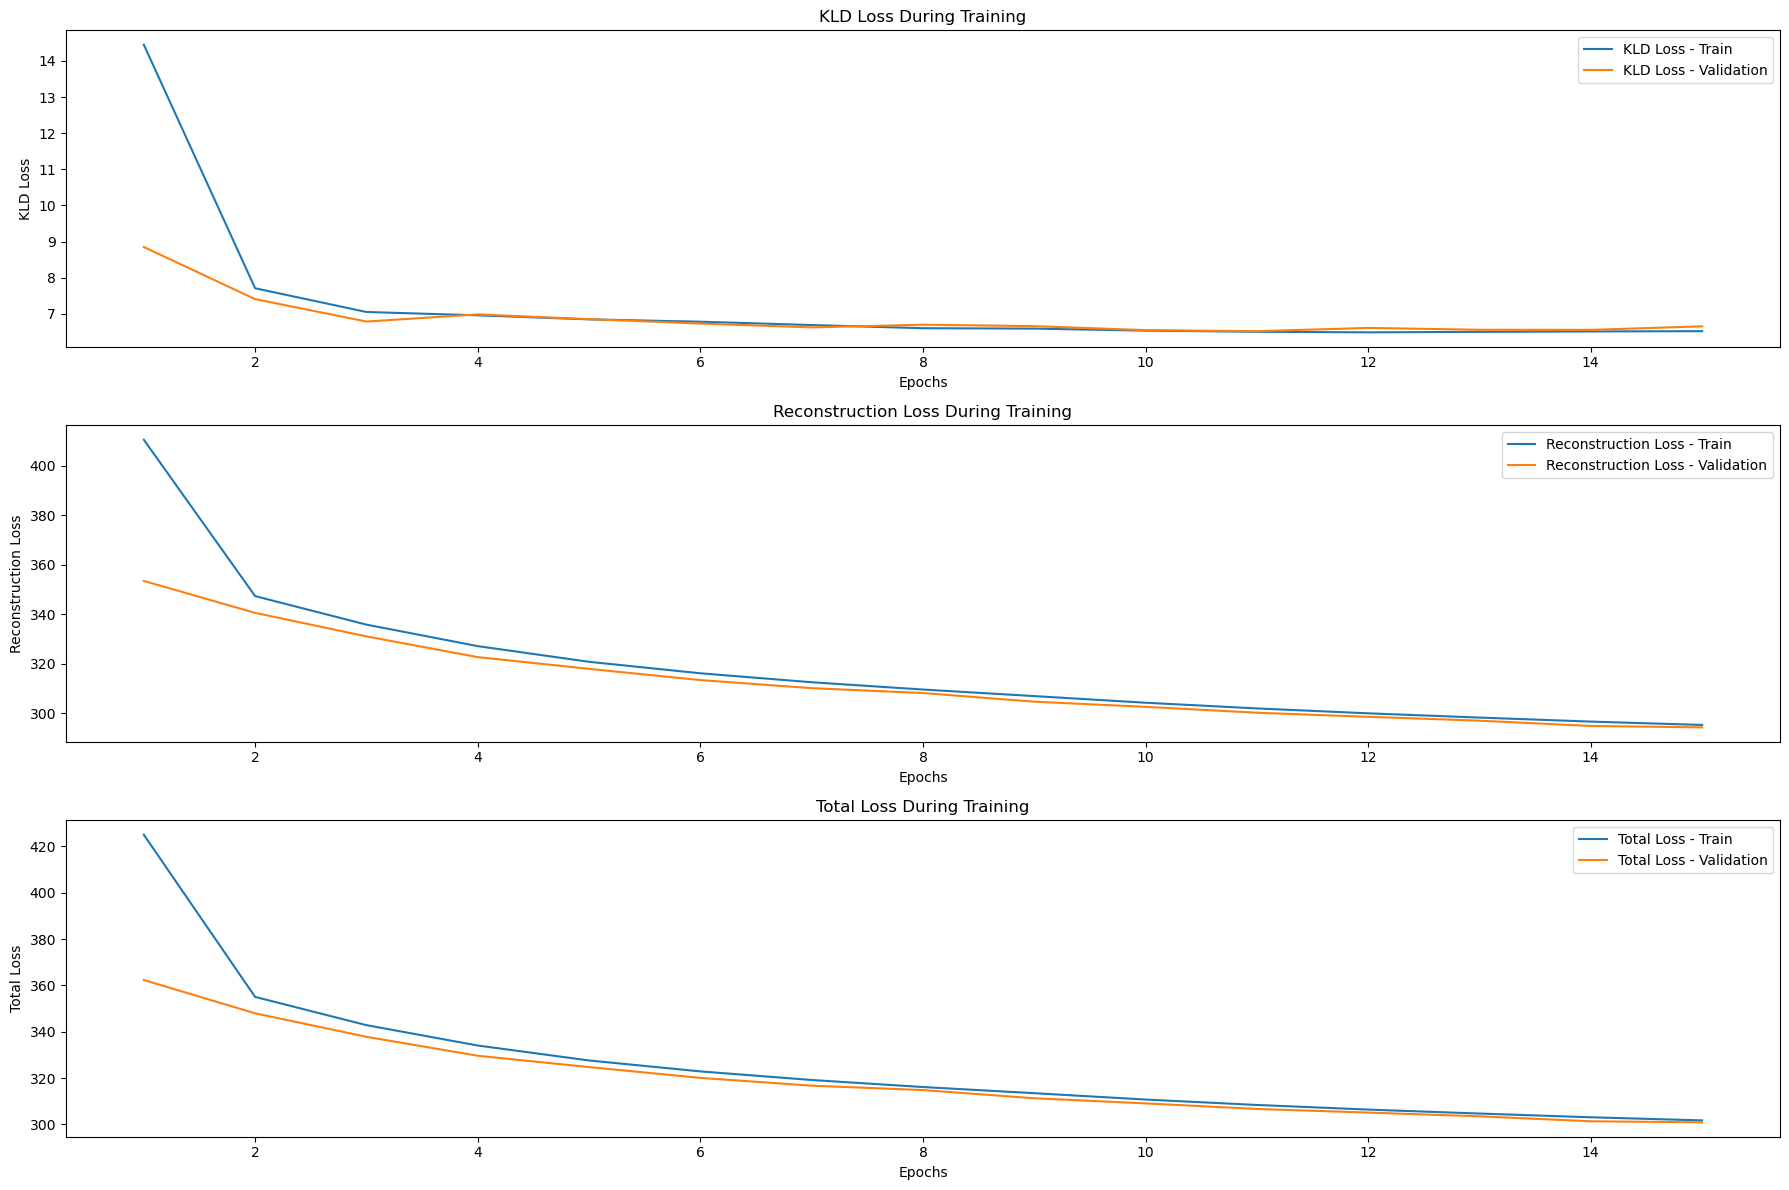

In [52]:
plot_training_history(gaussian_vae_trainer_perceptual_bce.history)

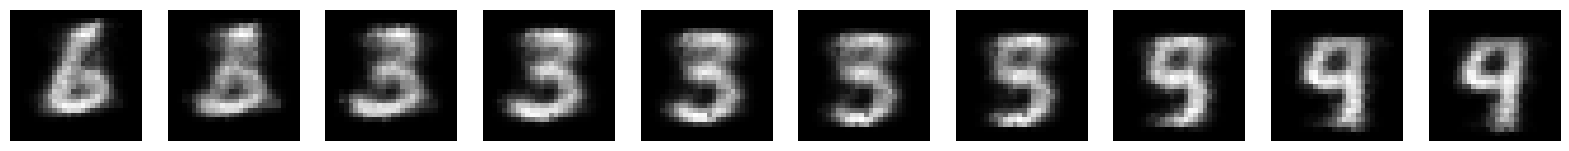

In [53]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,model=gaussian_vae_perceptual_bce)

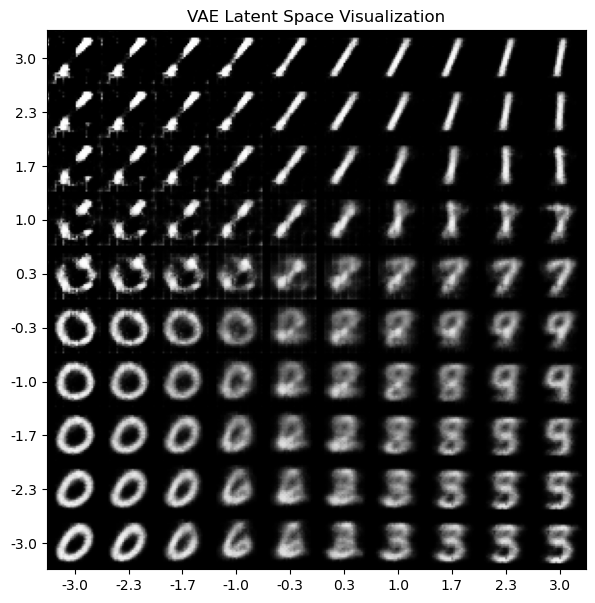

In [54]:
plot_latent_space(gaussian_vae_perceptual_bce,scale=3)

In [55]:
save(gaussian_vae_perceptual_bce,gaussian_vae_trainer_perceptual_bce,'models/gaussian(1,2)_improvements/perceptual_bce_kaiming_init.pt')

## <a id='toc4_6_'></a>[Weighted Perceptual Loss with MSE Loss as Reconstruction Loss](#toc0_)

In [26]:
torch.manual_seed(MANUAL_SEED)
gaussian_vae_perceptual_mse = NormalVAE(LATENT_DIM,1,2)
gaussian_optimizer_perceptual_mse = torch.optim.Adam(gaussian_vae_perceptual_mse.parameters(),lr=LEARNING_RATE)

initialize_weights(gaussian_vae_perceptual_mse)

perceptual_weight = 0.01

# I used second and 4th relu
selected_layers = (3,7)
reconstruction_loss_fn_perceptual_mse = WeightedPerceptual(selected_layers,
                                                       classifier.features,
                                                       DEVICE,
                                                       perceptual_weight,
                                                       nn.MSELoss,
                                                       reduction='sum')

In [27]:
gaussian_vae_trainer_perceptual_mse = VAETrainer(
    model=gaussian_vae_perceptual_mse,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=gaussian_optimizer_perceptual_mse,
    reconstruction_loss_fn=reconstruction_loss_fn_perceptual_mse,
    device=DEVICE
)

In [28]:
gaussian_vae_trainer_perceptual_mse.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:55<00:00, 16.94batch/s, kld_loss=211, loss=6.48e+3, recon_loss=6.27e+3]    


Epoch 1 Training - Total Loss: 252.2012, KLD Loss: 8.7652, Recon Loss: 243.4360


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 40.79batch/s, kld_loss=106, recon_loss=3.37e+3]


Epoch 1 Evaluation - Total Loss: 218.4998, KLD Loss: 6.1230, Recon Loss: 212.3768


Epoch 2/15: 100%|██████████| 938/938 [00:43<00:00, 21.80batch/s, kld_loss=214, loss=6.16e+3, recon_loss=5.94e+3]


Epoch 2 Training - Total Loss: 212.4245, KLD Loss: 5.9640, Recon Loss: 206.4605


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 37.25batch/s, kld_loss=110, recon_loss=3.22e+3]


Epoch 2 Evaluation - Total Loss: 206.5056, KLD Loss: 6.2039, Recon Loss: 200.3017


Epoch 3/15: 100%|██████████| 938/938 [00:47<00:00, 19.80batch/s, kld_loss=181, loss=5.7e+3, recon_loss=5.52e+3] 


Epoch 3 Training - Total Loss: 201.2978, KLD Loss: 6.0580, Recon Loss: 195.2398


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 39.73batch/s, kld_loss=104, recon_loss=3e+3]   


Epoch 3 Evaluation - Total Loss: 196.8167, KLD Loss: 5.9536, Recon Loss: 190.8631


Epoch 4/15: 100%|██████████| 938/938 [00:45<00:00, 20.72batch/s, kld_loss=170, loss=6.11e+3, recon_loss=5.94e+3]


Epoch 4 Training - Total Loss: 194.0753, KLD Loss: 6.0434, Recon Loss: 188.0319


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 45.68batch/s, kld_loss=103, recon_loss=2.99e+3]


Epoch 4 Evaluation - Total Loss: 191.6987, KLD Loss: 6.0264, Recon Loss: 185.6723


Epoch 5/15: 100%|██████████| 938/938 [00:42<00:00, 22.26batch/s, kld_loss=197, loss=6.61e+3, recon_loss=6.41e+3]


Epoch 5 Training - Total Loss: 190.0847, KLD Loss: 5.9262, Recon Loss: 184.1584


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 47.32batch/s, kld_loss=99.1, recon_loss=2.92e+3]


Epoch 5 Evaluation - Total Loss: 188.9002, KLD Loss: 5.8794, Recon Loss: 183.0207


Epoch 6/15: 100%|██████████| 938/938 [00:43<00:00, 21.78batch/s, kld_loss=175, loss=5.83e+3, recon_loss=5.66e+3]


Epoch 6 Training - Total Loss: 187.5515, KLD Loss: 5.8709, Recon Loss: 181.6806


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 46.39batch/s, kld_loss=97.4, recon_loss=2.85e+3]


Epoch 6 Evaluation - Total Loss: 186.7695, KLD Loss: 5.8451, Recon Loss: 180.9243


Epoch 7/15: 100%|██████████| 938/938 [00:42<00:00, 22.13batch/s, kld_loss=184, loss=6.02e+3, recon_loss=5.83e+3]


Epoch 7 Training - Total Loss: 185.4104, KLD Loss: 5.8584, Recon Loss: 179.5520


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 45.49batch/s, kld_loss=96.8, recon_loss=2.84e+3]


Epoch 7 Evaluation - Total Loss: 184.4536, KLD Loss: 5.8410, Recon Loss: 178.6126


Epoch 8/15: 100%|██████████| 938/938 [00:42<00:00, 22.05batch/s, kld_loss=203, loss=5e+3, recon_loss=4.8e+3]    


Epoch 8 Training - Total Loss: 183.4326, KLD Loss: 5.8108, Recon Loss: 177.6217


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 42.43batch/s, kld_loss=98.4, recon_loss=2.77e+3]


Epoch 8 Evaluation - Total Loss: 183.4472, KLD Loss: 5.9559, Recon Loss: 177.4913


Epoch 9/15: 100%|██████████| 938/938 [00:49<00:00, 18.84batch/s, kld_loss=189, loss=5.76e+3, recon_loss=5.57e+3]


Epoch 9 Training - Total Loss: 181.3850, KLD Loss: 5.8355, Recon Loss: 175.5495


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.29batch/s, kld_loss=97, recon_loss=2.75e+3] 


Epoch 9 Evaluation - Total Loss: 180.1833, KLD Loss: 5.8575, Recon Loss: 174.3258


Epoch 10/15: 100%|██████████| 938/938 [00:48<00:00, 19.14batch/s, kld_loss=192, loss=6.56e+3, recon_loss=6.37e+3]


Epoch 10 Training - Total Loss: 179.3476, KLD Loss: 5.8276, Recon Loss: 173.5200


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 43.15batch/s, kld_loss=96.8, recon_loss=2.77e+3]


Epoch 10 Evaluation - Total Loss: 178.2049, KLD Loss: 5.9135, Recon Loss: 172.2914


Epoch 11/15: 100%|██████████| 938/938 [00:41<00:00, 22.34batch/s, kld_loss=185, loss=6.2e+3, recon_loss=6.02e+3] 


Epoch 11 Training - Total Loss: 177.6410, KLD Loss: 5.8419, Recon Loss: 171.7991


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 19.42batch/s, kld_loss=96.5, recon_loss=2.73e+3]


Epoch 11 Evaluation - Total Loss: 176.6586, KLD Loss: 5.9233, Recon Loss: 170.7353


Epoch 12/15: 100%|██████████| 938/938 [00:44<00:00, 20.88batch/s, kld_loss=172, loss=6.41e+3, recon_loss=6.23e+3]


Epoch 12 Training - Total Loss: 176.1853, KLD Loss: 5.8522, Recon Loss: 170.3331


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 46.83batch/s, kld_loss=95.2, recon_loss=2.68e+3]


Epoch 12 Evaluation - Total Loss: 175.3758, KLD Loss: 5.9136, Recon Loss: 169.4622


Epoch 13/15: 100%|██████████| 938/938 [00:42<00:00, 21.96batch/s, kld_loss=187, loss=6.07e+3, recon_loss=5.88e+3]


Epoch 13 Training - Total Loss: 174.8723, KLD Loss: 5.8819, Recon Loss: 168.9904


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 47.67batch/s, kld_loss=95.8, recon_loss=2.7e+3]


Epoch 13 Evaluation - Total Loss: 174.7424, KLD Loss: 5.9319, Recon Loss: 168.8105


Epoch 14/15: 100%|██████████| 938/938 [00:41<00:00, 22.52batch/s, kld_loss=195, loss=5.4e+3, recon_loss=5.2e+3]  


Epoch 14 Training - Total Loss: 173.6546, KLD Loss: 5.8992, Recon Loss: 167.7555


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.98batch/s, kld_loss=94.8, recon_loss=2.67e+3]


Epoch 14 Evaluation - Total Loss: 173.5156, KLD Loss: 5.9469, Recon Loss: 167.5687


Epoch 15/15: 100%|██████████| 938/938 [00:45<00:00, 20.76batch/s, kld_loss=193, loss=5.9e+3, recon_loss=5.7e+3]  


Epoch 15 Training - Total Loss: 172.6890, KLD Loss: 5.9366, Recon Loss: 166.7524


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.70batch/s, kld_loss=95.4, recon_loss=2.61e+3]


Epoch 15 Evaluation - Total Loss: 172.3108, KLD Loss: 5.9811, Recon Loss: 166.3297


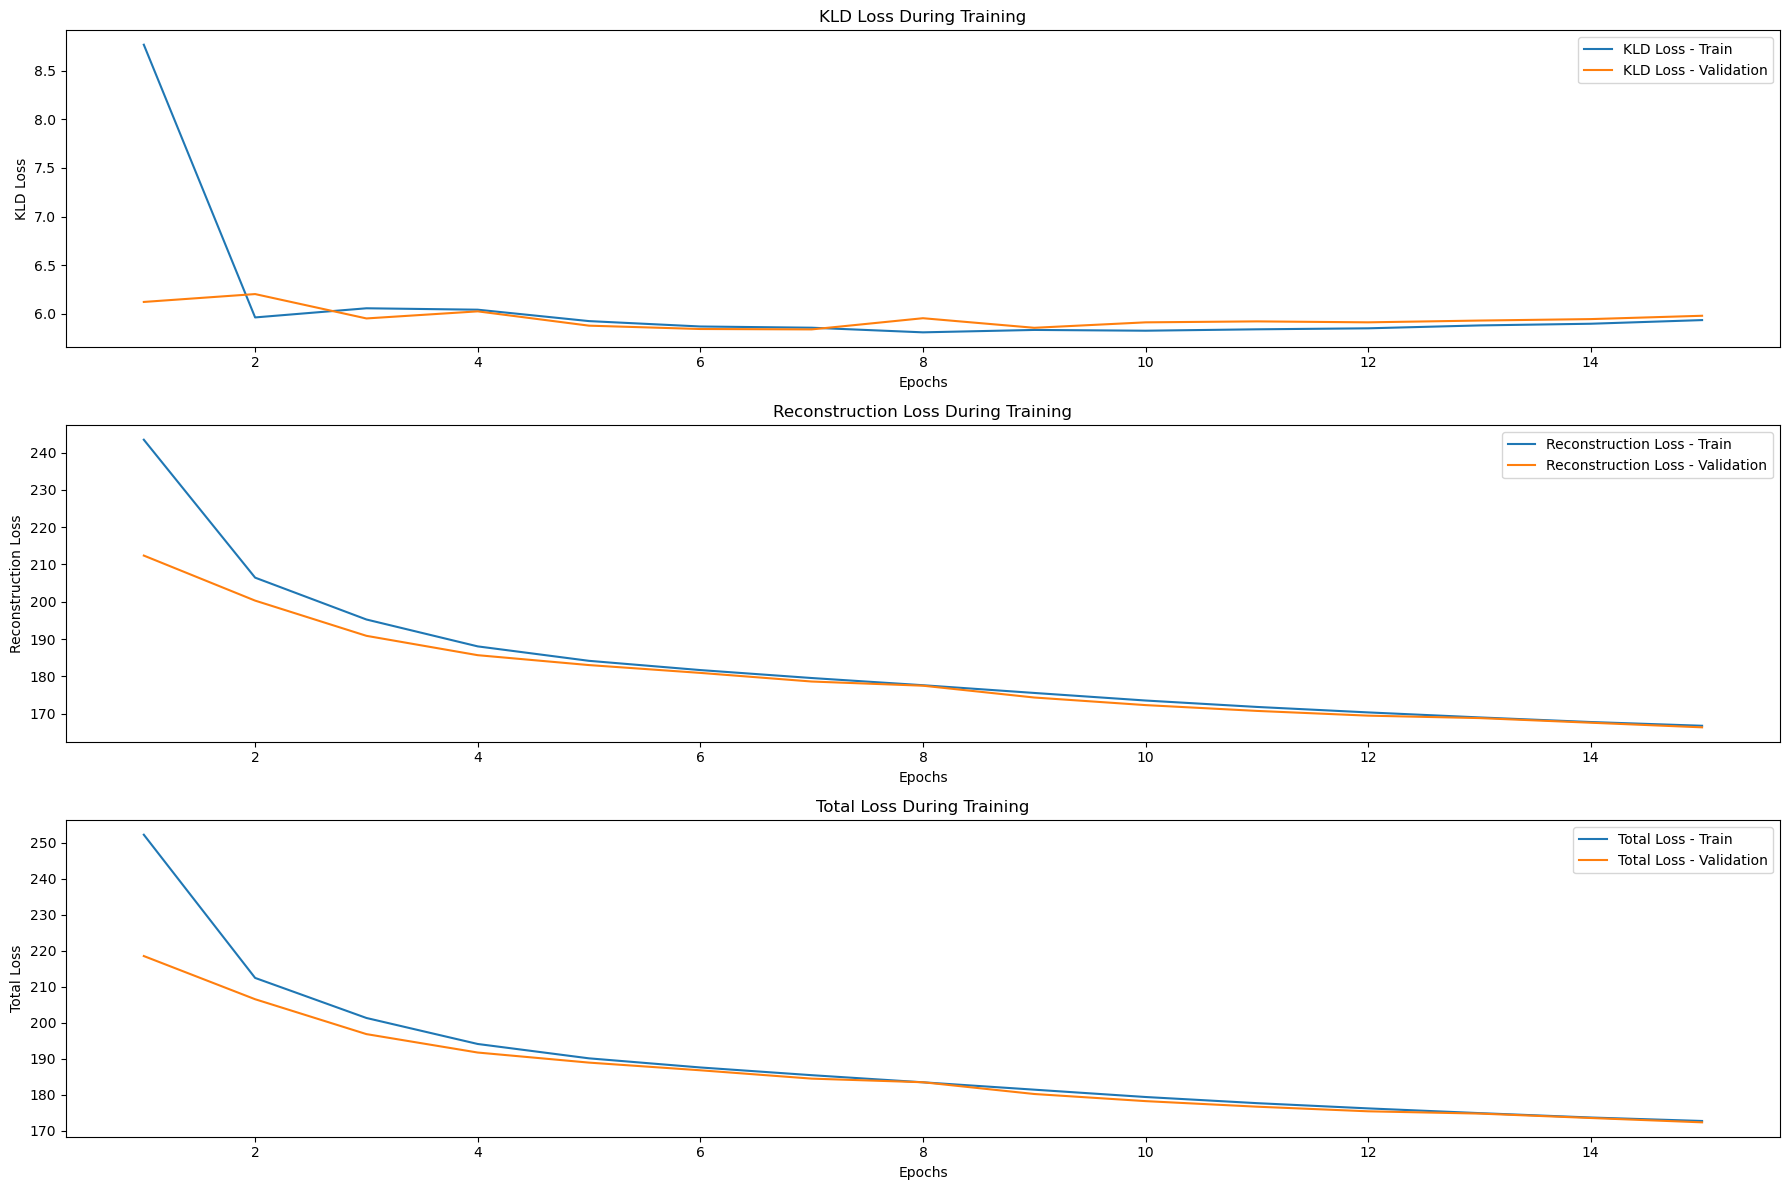

In [29]:
plot_training_history(gaussian_vae_trainer_perceptual_mse.history)

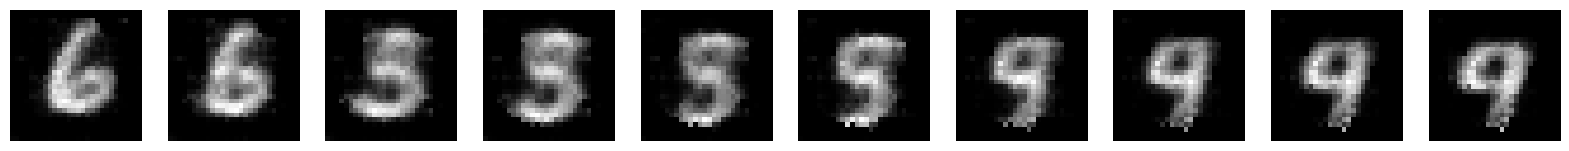

In [30]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,model=gaussian_vae_perceptual_mse)

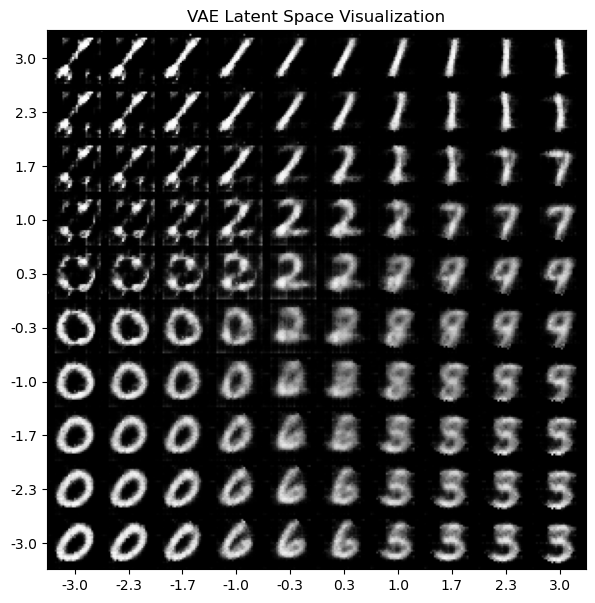

In [31]:
plot_latent_space(gaussian_vae_perceptual_mse,scale=3)

In [67]:
save(gaussian_vae_perceptual_mse,gaussian_vae_trainer_perceptual_mse,'models/gaussian(1,2)_improvements/perceptual_mse_kaiming_init.pt')

# <a id='toc5_'></a>[Reconstructions](#toc0_)

Two of the best performing models are the models with kaiming he initialisation and bce loss and another one weighted perceptual loss. We will compare the reconstructions they are able to perform.

In [21]:
def fetch_all_digits_index(dataset):
    """Returns indexes of all the handwritten digits."""
    index_dict = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
    
    for i,(_,label) in enumerate(dataset):
        index_dict[label].append(i)
        
    return index_dict

In [22]:
dictionary_index = fetch_all_digits_index(test_dataset)

In [23]:
INDEX = 3

In [25]:
def reconstruct_and_plot_digits(dataset, index_dict, vae_model):
    """
    Reconstructs one instance of each digit using a VAE model and plots them alongside the originals.

    Parameters:
    - index (int): index to be taken for reconstruction.
    - data_loader (torch.utils.data.Dataset): Dataset for the dataset containing MNIST digits.
    - index_dict (dict): Dictionary containing indices for each digit in their corresponding lists.
    - vae_model (torch.nn.Module): Trained VAE model for generating reconstructions.
    """

    vae_model.to(DEVICE)
    vae_model.eval()
    
    # Fetch one instance of each digit
    original_images = []
    reconstructed_images = []
    for digit, indices in index_dict.items():
        index = indices[INDEX]  # Take the first index for each digit
        image, _ = dataset[index]
        original_images.append(image)

        # Move the image to the device and add a batch dimension
        image = image.to(DEVICE).unsqueeze(0)
        with torch.no_grad():
            # Forward pass through the VAE model to get the reconstruction
            reconstruction, _, _ = vae_model(image)
        reconstructed_images.append(reconstruction.squeeze(0))  # Remove batch dimension

    # Plot the original and reconstructed images
    fig, axs = plt.subplots(2, 10, figsize=(20, 4))
    for i, (original, reconstructed) in enumerate(zip(original_images, reconstructed_images)):
        axs[0, i].imshow(original.squeeze().cpu().numpy(), cmap='gray')
        axs[0, i].set_title(f'Original {i}')
        axs[0, i].axis('off')
        
        axs[1, i].imshow(reconstructed.squeeze().cpu().numpy(), cmap='gray')
        axs[1, i].set_title(f'Reconstructed {i}')
        axs[1, i].axis('off')

    plt.show()

## <a id='toc5_1_'></a>[BCE Loss](#toc0_)

In [103]:
bce_loss_vae = NormalVAE(LATENT_DIM,1,2)
bce_loss_vae.load_state_dict(torch.load('models/gaussian(1,2)_improvements/kaiming_init.pt')['state_dict'])

<All keys matched successfully>

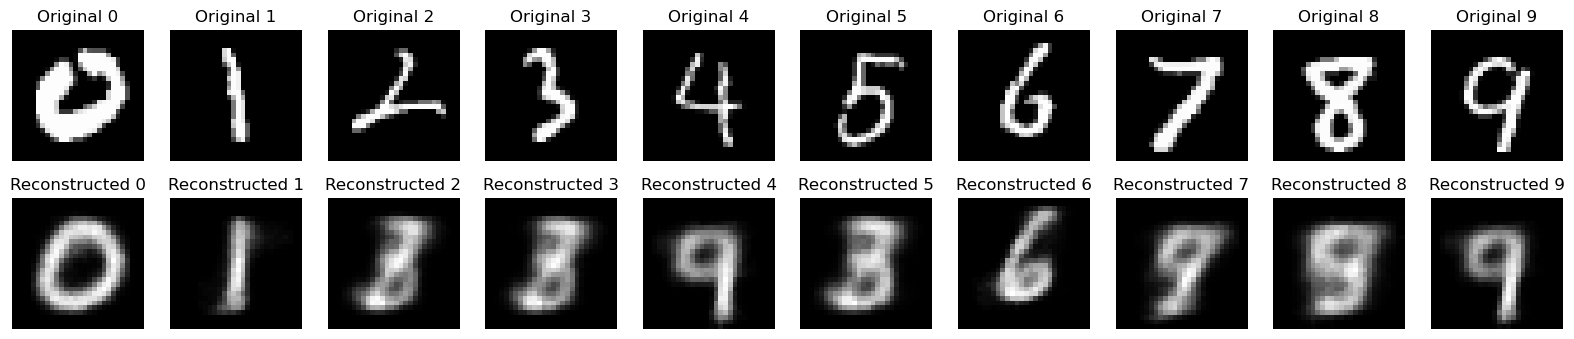

In [104]:
reconstruct_and_plot_digits(test_dataset,dictionary_index,bce_loss_vae)

## <a id='toc5_2_'></a>[Weighted Perceptual Loss with BCE Loss](#toc0_)

In [105]:
perceptual_bce_loss_vae = NormalVAE(LATENT_DIM,1,2)
perceptual_bce_loss_vae.load_state_dict(torch.load('models/gaussian(1,2)_improvements/perceptual_bce_kaiming_init.pt')['state_dict'])

<All keys matched successfully>

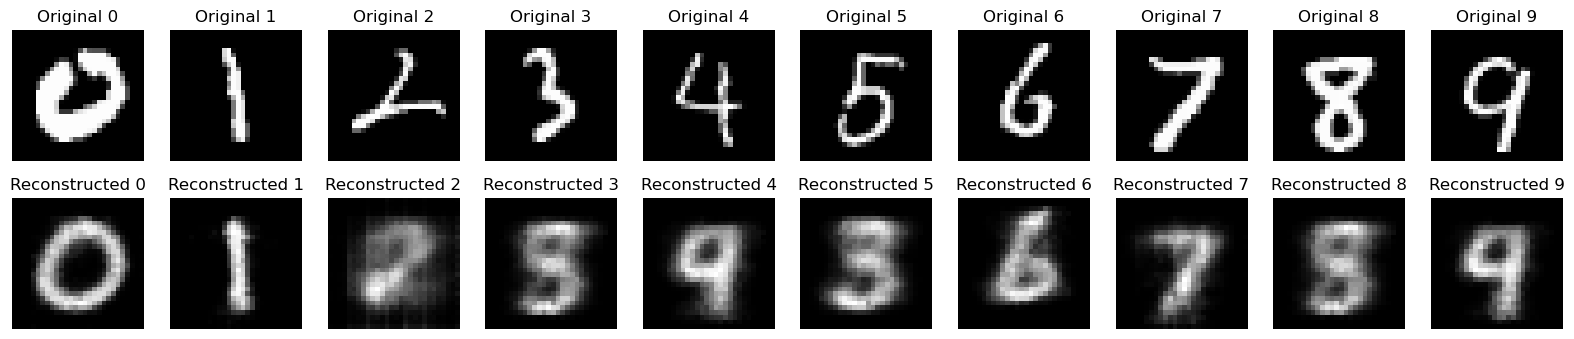

In [106]:
reconstruct_and_plot_digits(test_dataset,dictionary_index,perceptual_bce_loss_vae)

# <a id='toc6_'></a>[10D Latent Space](#toc0_)

In [139]:
def slerp(q_1: torch.Tensor,
          q_2: torch.Tensor,
          theta: torch.Tensor,
          mu: float):
    """Calculate spherical linear interpolation."""
    assert 0<=mu<=1, "Mu should be in between"
    term1 = torch.sin((1-mu)*theta)/torch.sin(theta)
    term2 = torch.sin(mu*theta)/torch.sin(theta)
    slerp = q_1*term1 + q_2*term2
    
    return slerp

def interpolate_and_plot_spherical(image1: torch.Tensor, 
                                   image2: torch.Tensor, 
                                   model: BaseVAE, 
                                   steps: int = 10):
    """
    Interpolates spherically between two images using their latent space representations
    and plots the interpolation results.

    Parameters:
    - image1 (torch.Tensor): The first image tensor.
    - image2 (torch.Tensor): The second image tensor.
    - model (torch.nn.Module): The VAE model for encoding and decoding.
    - steps (int): The number of interpolation steps, including the start and end images.
    """
    model.eval()  # Set the model to evaluation mode
    
    # Encode images to latent vectors
    with torch.no_grad():
        image1_param1,image1_param2 = model.encode(image1.unsqueeze(0))
        z1 = model.reparameterise(image1_param1,image1_param2) 
        image2_param1,image2_param2 = model.encode(image2.unsqueeze(0))
        z2 = model.reparameterise(image2_param1,image2_param2) 
    
    inner_prod = torch.dot(z1.squeeze(0),z2.squeeze(0))
    norm = torch.norm(z1)*torch.norm(z2)
    theta = torch.arccos(torch.clamp(inner_prod/norm, -1, 1))
    
    # Interpolate in the latent space
    interpolated_z = [slerp(z1,z2,theta,mu) for mu in np.linspace(0, 1, steps)]
    
    # Decode the interpolated vectors
    interpolated_images = [model.decode(z).squeeze(0) for z in interpolated_z]
    
    # Plotting
    fig, axes = plt.subplots(1, steps, figsize=(20, 2))
    with torch.no_grad():
        for i, img in enumerate(interpolated_images):
            axes[i].imshow(img.squeeze().cpu().numpy(), cmap='gray')
            axes[i].axis('off')
    plt.show()

## <a id='toc6_1_'></a>[BCE Loss](#toc0_)

In [32]:
torch.manual_seed(MANUAL_SEED)
ten_dimensional_vae_bce = NormalVAE(10,1,2)
ten_dimensional_vae_bce_optim = torch.optim.Adam(ten_dimensional_vae_bce.parameters(),lr=LEARNING_RATE)

initialize_weights(ten_dimensional_vae_bce)

reconstruction_loss_fn_four_d = nn.BCELoss(reduction='sum')

In [33]:
ten_dimensional_vae_bce_trainer = VAETrainer(
    model=ten_dimensional_vae_bce,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=ten_dimensional_vae_bce_optim,
    reconstruction_loss_fn=reconstruction_loss_fn_four_d,
    device=DEVICE
)

In [34]:
ten_dimensional_vae_bce_trainer.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:29<00:00, 31.89batch/s, kld_loss=463, loss=4.95e+3, recon_loss=4.49e+3]    


Epoch 1 Training - Total Loss: 225.6634, KLD Loss: 14.9963, Recon Loss: 210.6672


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 77.58batch/s, kld_loss=263, recon_loss=2.09e+3]    


Epoch 1 Evaluation - Total Loss: 151.0638, KLD Loss: 15.1369, Recon Loss: 135.9269


Epoch 2/15: 100%|██████████| 938/938 [00:29<00:00, 32.20batch/s, kld_loss=558, loss=4.13e+3, recon_loss=3.57e+3]    


Epoch 2 Training - Total Loss: 139.2689, KLD Loss: 16.2950, Recon Loss: 122.9739


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 73.21batch/s, kld_loss=285, recon_loss=1.74e+3]    


Epoch 2 Evaluation - Total Loss: 131.1598, KLD Loss: 16.7931, Recon Loss: 114.3667


Epoch 3/15: 100%|██████████| 938/938 [00:28<00:00, 32.49batch/s, kld_loss=547, loss=4.11e+3, recon_loss=3.56e+3]    


Epoch 3 Training - Total Loss: 129.1560, KLD Loss: 16.9350, Recon Loss: 112.2210


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 71.70batch/s, kld_loss=284, recon_loss=1.66e+3]    


Epoch 3 Evaluation - Total Loss: 125.5974, KLD Loss: 17.1044, Recon Loss: 108.4930


Epoch 4/15: 100%|██████████| 938/938 [00:31<00:00, 30.19batch/s, kld_loss=583, loss=4.21e+3, recon_loss=3.62e+3]    


Epoch 4 Training - Total Loss: 124.8968, KLD Loss: 17.2892, Recon Loss: 107.6077


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 73.69batch/s, kld_loss=288, recon_loss=1.62e+3]    


Epoch 4 Evaluation - Total Loss: 122.2374, KLD Loss: 17.4687, Recon Loss: 104.7686


Epoch 5/15: 100%|██████████| 938/938 [00:31<00:00, 29.59batch/s, kld_loss=544, loss=3.59e+3, recon_loss=3.05e+3]    


Epoch 5 Training - Total Loss: 122.1827, KLD Loss: 17.5829, Recon Loss: 104.5997


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 69.04batch/s, kld_loss=288, recon_loss=1.6e+3]     


Epoch 5 Evaluation - Total Loss: 120.0253, KLD Loss: 17.6162, Recon Loss: 102.4091


Epoch 6/15: 100%|██████████| 938/938 [00:30<00:00, 30.46batch/s, kld_loss=591, loss=3.82e+3, recon_loss=3.23e+3]    


Epoch 6 Training - Total Loss: 120.2455, KLD Loss: 17.8519, Recon Loss: 102.3936


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.48batch/s, kld_loss=297, recon_loss=1.54e+3]    


Epoch 6 Evaluation - Total Loss: 118.5041, KLD Loss: 18.1971, Recon Loss: 100.3070


Epoch 7/15: 100%|██████████| 938/938 [00:28<00:00, 33.30batch/s, kld_loss=580, loss=3.87e+3, recon_loss=3.29e+3]    


Epoch 7 Training - Total Loss: 118.7654, KLD Loss: 18.0641, Recon Loss: 100.7013


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 78.13batch/s, kld_loss=292, recon_loss=1.56e+3]    


Epoch 7 Evaluation - Total Loss: 117.0829, KLD Loss: 17.9412, Recon Loss: 99.1417


Epoch 8/15: 100%|██████████| 938/938 [00:28<00:00, 32.96batch/s, kld_loss=601, loss=4.06e+3, recon_loss=3.46e+3]    


Epoch 8 Training - Total Loss: 117.6091, KLD Loss: 18.2214, Recon Loss: 99.3876


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.31batch/s, kld_loss=297, recon_loss=1.49e+3]    


Epoch 8 Evaluation - Total Loss: 116.1251, KLD Loss: 18.3392, Recon Loss: 97.7859


Epoch 9/15: 100%|██████████| 938/938 [00:30<00:00, 30.73batch/s, kld_loss=589, loss=3.82e+3, recon_loss=3.23e+3]    


Epoch 9 Training - Total Loss: 116.6602, KLD Loss: 18.3387, Recon Loss: 98.3216


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 69.42batch/s, kld_loss=299, recon_loss=1.5e+3]     


Epoch 9 Evaluation - Total Loss: 115.1962, KLD Loss: 18.5137, Recon Loss: 96.6825


Epoch 10/15: 100%|██████████| 938/938 [00:32<00:00, 29.19batch/s, kld_loss=587, loss=3.6e+3, recon_loss=3.01e+3]     


Epoch 10 Training - Total Loss: 115.8343, KLD Loss: 18.4354, Recon Loss: 97.3988


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 61.95batch/s, kld_loss=298, recon_loss=1.5e+3]     


Epoch 10 Evaluation - Total Loss: 114.6444, KLD Loss: 18.4160, Recon Loss: 96.2284


Epoch 11/15: 100%|██████████| 938/938 [00:31<00:00, 29.88batch/s, kld_loss=598, loss=3.7e+3, recon_loss=3.1e+3]      


Epoch 11 Training - Total Loss: 115.2159, KLD Loss: 18.5014, Recon Loss: 96.7144


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 77.20batch/s, kld_loss=298, recon_loss=1.49e+3]    


Epoch 11 Evaluation - Total Loss: 114.0881, KLD Loss: 18.4648, Recon Loss: 95.6232


Epoch 12/15: 100%|██████████| 938/938 [00:27<00:00, 33.71batch/s, kld_loss=602, loss=3.96e+3, recon_loss=3.36e+3]    


Epoch 12 Training - Total Loss: 114.6391, KLD Loss: 18.5768, Recon Loss: 96.0624


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 78.85batch/s, kld_loss=300, recon_loss=1.45e+3]    


Epoch 12 Evaluation - Total Loss: 113.7448, KLD Loss: 18.5533, Recon Loss: 95.1915


Epoch 13/15: 100%|██████████| 938/938 [00:29<00:00, 31.30batch/s, kld_loss=603, loss=3.71e+3, recon_loss=3.1e+3]     


Epoch 13 Training - Total Loss: 114.1681, KLD Loss: 18.6227, Recon Loss: 95.5454


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 67.54batch/s, kld_loss=304, recon_loss=1.42e+3]    


Epoch 13 Evaluation - Total Loss: 113.1607, KLD Loss: 18.7731, Recon Loss: 94.3876


Epoch 14/15: 100%|██████████| 938/938 [00:28<00:00, 32.64batch/s, kld_loss=579, loss=3.58e+3, recon_loss=3e+3]       


Epoch 14 Training - Total Loss: 113.7432, KLD Loss: 18.6809, Recon Loss: 95.0623


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.45batch/s, kld_loss=301, recon_loss=1.45e+3]    


Epoch 14 Evaluation - Total Loss: 112.7821, KLD Loss: 18.6830, Recon Loss: 94.0991


Epoch 15/15: 100%|██████████| 938/938 [00:35<00:00, 26.10batch/s, kld_loss=602, loss=3.57e+3, recon_loss=2.97e+3]    


Epoch 15 Training - Total Loss: 113.3564, KLD Loss: 18.7266, Recon Loss: 94.6298


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 78.28batch/s, kld_loss=303, recon_loss=1.44e+3]    

Epoch 15 Evaluation - Total Loss: 112.3006, KLD Loss: 18.7876, Recon Loss: 93.5130


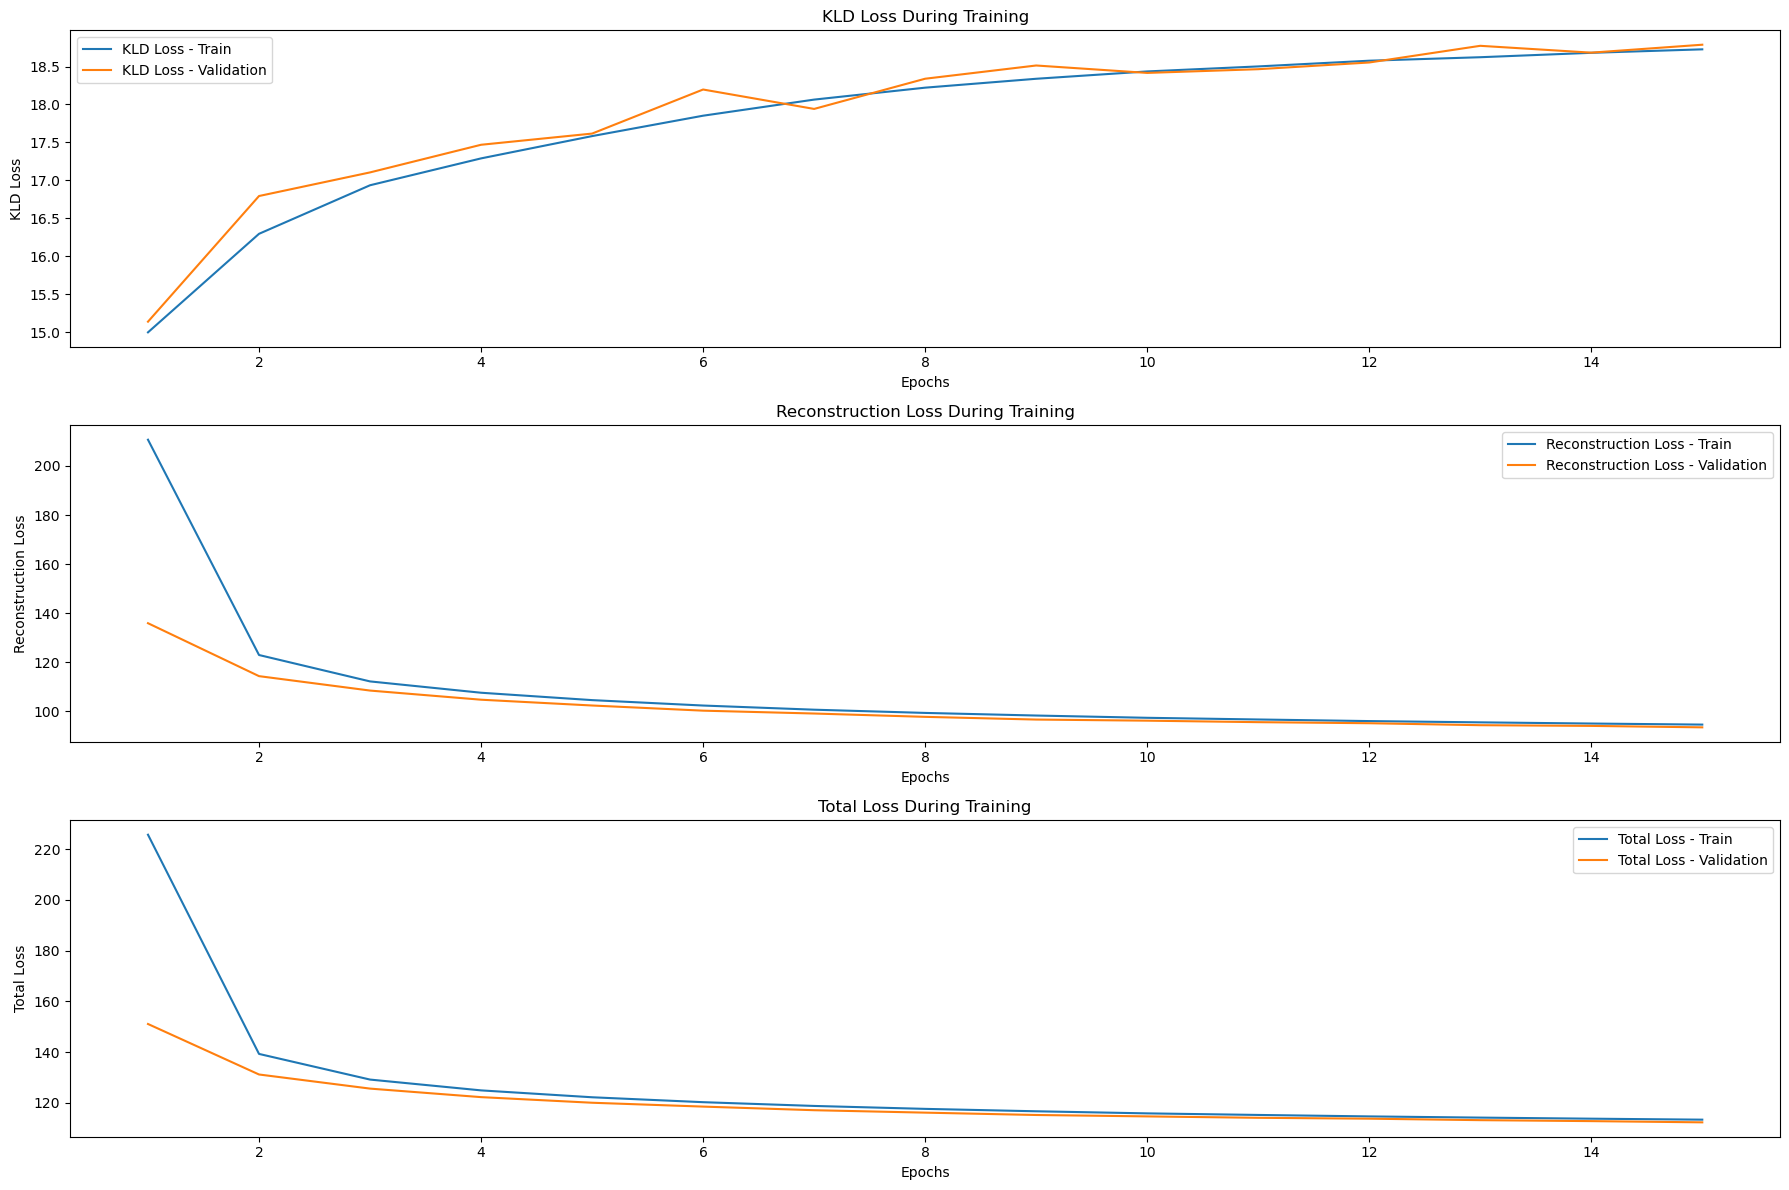

In [35]:
plot_training_history(ten_dimensional_vae_bce_trainer.history)

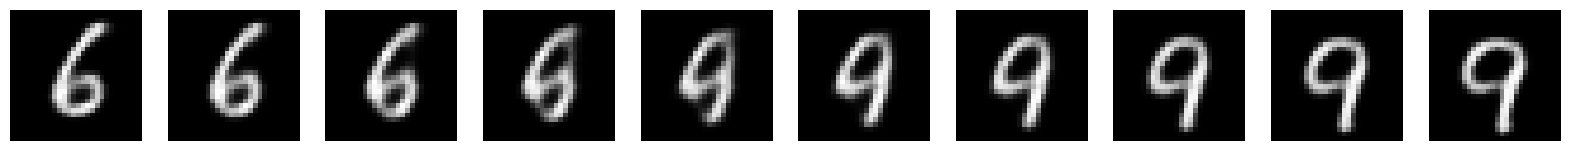

In [36]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,model=ten_dimensional_vae_bce)

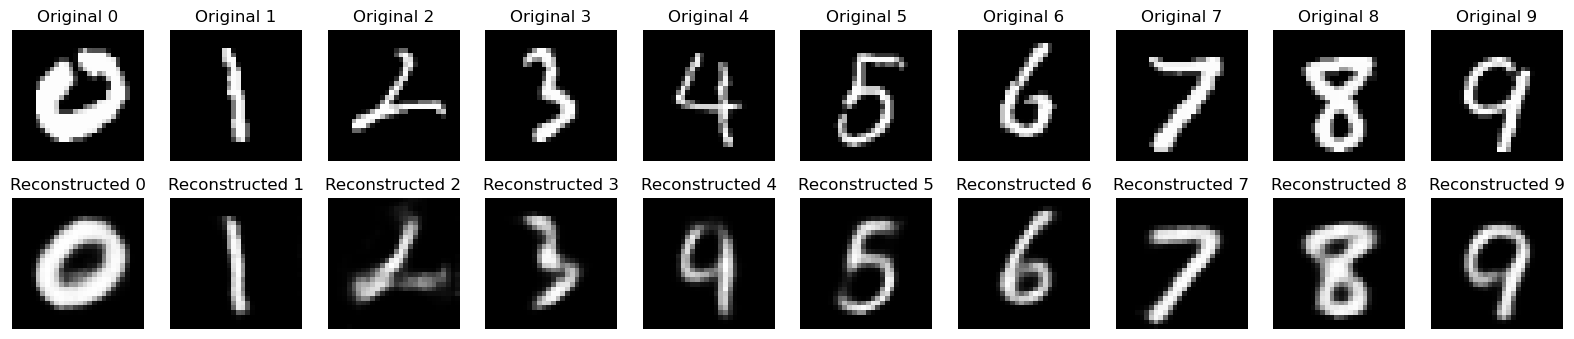

In [37]:
reconstruct_and_plot_digits(test_dataset,dictionary_index,ten_dimensional_vae_bce)

In [38]:
save(ten_dimensional_vae_bce,ten_dimensional_vae_bce_trainer,'models/10D_vae_gaussian.pt')

## <a id='toc6_2_'></a>[Weighted Perceptual Loss with BCE Loss](#toc0_)

In [13]:
torch.manual_seed(MANUAL_SEED)
gaussian_vae_perceptual_bce_tend = NormalVAE(10,1,2)
gaussian_optimizer_perceptual_bce_tend = torch.optim.Adam(gaussian_vae_perceptual_bce_tend.parameters(),lr=LEARNING_RATE)

initialize_weights(gaussian_vae_perceptual_bce_tend)

perceptual_weight = 0.01

# I used second and 4th relu
selected_layers = (3,7)
reconstruction_loss_fn_perceptual_bce_tend = WeightedPerceptual(selected_layers,
                                                       classifier.features,
                                                       DEVICE,
                                                       perceptual_weight,
                                                       nn.BCELoss,
                                                       reduction='sum')

In [14]:
gaussian_vae_trainer_perceptual_bce_tend = VAETrainer(
    model=gaussian_vae_perceptual_bce_tend,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=gaussian_optimizer_perceptual_bce_tend,
    reconstruction_loss_fn=reconstruction_loss_fn_perceptual_bce_tend,
    device=DEVICE
)

In [15]:
gaussian_vae_trainer_perceptual_bce_tend.train(EPOCHS)

Epoch 1/15: 100%|██████████| 938/938 [00:43<00:00, 21.57batch/s, kld_loss=786, loss=7.4e+3, recon_loss=6.61e+3]     


Epoch 1 Training - Total Loss: 367.3844, KLD Loss: 24.8430, Recon Loss: 342.5414


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 39.78batch/s, kld_loss=409, recon_loss=3.38e+3]    


Epoch 1 Evaluation - Total Loss: 228.3156, KLD Loss: 25.0890, Recon Loss: 203.2266


Epoch 2/15: 100%|██████████| 938/938 [00:43<00:00, 21.37batch/s, kld_loss=781, loss=6.05e+3, recon_loss=5.27e+3]    


Epoch 2 Training - Total Loss: 210.5696, KLD Loss: 23.9493, Recon Loss: 186.6204


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 40.84batch/s, kld_loss=381, recon_loss=2.7e+3]     


Epoch 2 Evaluation - Total Loss: 195.3862, KLD Loss: 23.5066, Recon Loss: 171.8796


Epoch 3/15: 100%|██████████| 938/938 [00:49<00:00, 18.83batch/s, kld_loss=746, loss=5.85e+3, recon_loss=5.1e+3]     


Epoch 3 Training - Total Loss: 190.1175, KLD Loss: 23.3337, Recon Loss: 166.7839


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 42.60batch/s, kld_loss=378, recon_loss=2.5e+3]     


Epoch 3 Evaluation - Total Loss: 182.8267, KLD Loss: 23.4413, Recon Loss: 159.3854


Epoch 4/15: 100%|██████████| 938/938 [00:43<00:00, 21.67batch/s, kld_loss=764, loss=6.01e+3, recon_loss=5.25e+3]    


Epoch 4 Training - Total Loss: 180.2873, KLD Loss: 23.2996, Recon Loss: 156.9876


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.73batch/s, kld_loss=377, recon_loss=2.36e+3]    


Epoch 4 Evaluation - Total Loss: 175.0930, KLD Loss: 23.5278, Recon Loss: 151.5652


Epoch 5/15: 100%|██████████| 938/938 [00:46<00:00, 20.33batch/s, kld_loss=716, loss=4.98e+3, recon_loss=4.27e+3]    


Epoch 5 Training - Total Loss: 174.1752, KLD Loss: 23.3241, Recon Loss: 150.8511


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 42.91batch/s, kld_loss=371, recon_loss=2.29e+3]    


Epoch 5 Evaluation - Total Loss: 170.5111, KLD Loss: 23.3186, Recon Loss: 147.1925


Epoch 6/15: 100%|██████████| 938/938 [00:45<00:00, 20.84batch/s, kld_loss=775, loss=5.38e+3, recon_loss=4.61e+3]    


Epoch 6 Training - Total Loss: 170.0850, KLD Loss: 23.3767, Recon Loss: 146.7083


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 28.69batch/s, kld_loss=377, recon_loss=2.24e+3]    


Epoch 6 Evaluation - Total Loss: 167.2053, KLD Loss: 23.6906, Recon Loss: 143.5147


Epoch 7/15: 100%|██████████| 938/938 [00:49<00:00, 18.88batch/s, kld_loss=742, loss=5.35e+3, recon_loss=4.61e+3]    


Epoch 7 Training - Total Loss: 167.0639, KLD Loss: 23.4648, Recon Loss: 143.5991


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.80batch/s, kld_loss=371, recon_loss=2.2e+3]     


Epoch 7 Evaluation - Total Loss: 164.4029, KLD Loss: 23.2665, Recon Loss: 141.1364


Epoch 8/15: 100%|██████████| 938/938 [00:43<00:00, 21.65batch/s, kld_loss=776, loss=5.85e+3, recon_loss=5.07e+3]    


Epoch 8 Training - Total Loss: 164.6700, KLD Loss: 23.5089, Recon Loss: 141.1610


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.57batch/s, kld_loss=374, recon_loss=2.18e+3]    


Epoch 8 Evaluation - Total Loss: 162.7975, KLD Loss: 23.5470, Recon Loss: 139.2505


Epoch 9/15: 100%|██████████| 938/938 [00:46<00:00, 20.38batch/s, kld_loss=751, loss=5.44e+3, recon_loss=4.69e+3]    


Epoch 9 Training - Total Loss: 162.8007, KLD Loss: 23.5863, Recon Loss: 139.2144


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 38.09batch/s, kld_loss=377, recon_loss=2.12e+3]    


Epoch 9 Evaluation - Total Loss: 160.9284, KLD Loss: 23.6866, Recon Loss: 137.2418


Epoch 10/15: 100%|██████████| 938/938 [00:44<00:00, 21.14batch/s, kld_loss=751, loss=4.88e+3, recon_loss=4.12e+3]    


Epoch 10 Training - Total Loss: 161.2274, KLD Loss: 23.6539, Recon Loss: 137.5735


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 39.61batch/s, kld_loss=380, recon_loss=2.08e+3]    


Epoch 10 Evaluation - Total Loss: 159.6788, KLD Loss: 23.8263, Recon Loss: 135.8525


Epoch 11/15: 100%|██████████| 938/938 [00:44<00:00, 20.91batch/s, kld_loss=759, loss=5.13e+3, recon_loss=4.37e+3]    


Epoch 11 Training - Total Loss: 159.8291, KLD Loss: 23.6526, Recon Loss: 136.1765


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.15batch/s, kld_loss=378, recon_loss=2.06e+3]    


Epoch 11 Evaluation - Total Loss: 158.4693, KLD Loss: 23.7235, Recon Loss: 134.7458


Epoch 12/15: 100%|██████████| 938/938 [00:43<00:00, 21.50batch/s, kld_loss=771, loss=5.24e+3, recon_loss=4.47e+3]    


Epoch 12 Training - Total Loss: 158.6112, KLD Loss: 23.6911, Recon Loss: 134.9201


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.77batch/s, kld_loss=380, recon_loss=2.03e+3]    


Epoch 12 Evaluation - Total Loss: 157.1806, KLD Loss: 23.7981, Recon Loss: 133.3825


Epoch 13/15: 100%|██████████| 938/938 [00:44<00:00, 21.29batch/s, kld_loss=768, loss=5.01e+3, recon_loss=4.24e+3]    


Epoch 13 Training - Total Loss: 157.5960, KLD Loss: 23.7337, Recon Loss: 133.8623


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 42.78batch/s, kld_loss=381, recon_loss=2.01e+3]    


Epoch 13 Evaluation - Total Loss: 156.7186, KLD Loss: 23.8723, Recon Loss: 132.8463


Epoch 14/15: 100%|██████████| 938/938 [00:43<00:00, 21.44batch/s, kld_loss=747, loss=4.94e+3, recon_loss=4.2e+3]     


Epoch 14 Training - Total Loss: 156.6638, KLD Loss: 23.7610, Recon Loss: 132.9028


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 40.66batch/s, kld_loss=379, recon_loss=1.99e+3]    


Epoch 14 Evaluation - Total Loss: 155.4938, KLD Loss: 23.8248, Recon Loss: 131.6690


Epoch 15/15: 100%|██████████| 938/938 [00:43<00:00, 21.34batch/s, kld_loss=767, loss=4.76e+3, recon_loss=3.99e+3]    


Epoch 15 Training - Total Loss: 155.8810, KLD Loss: 23.8234, Recon Loss: 132.0576


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 39.93batch/s, kld_loss=381, recon_loss=1.98e+3]    

Epoch 15 Evaluation - Total Loss: 154.7839, KLD Loss: 23.8785, Recon Loss: 130.9054


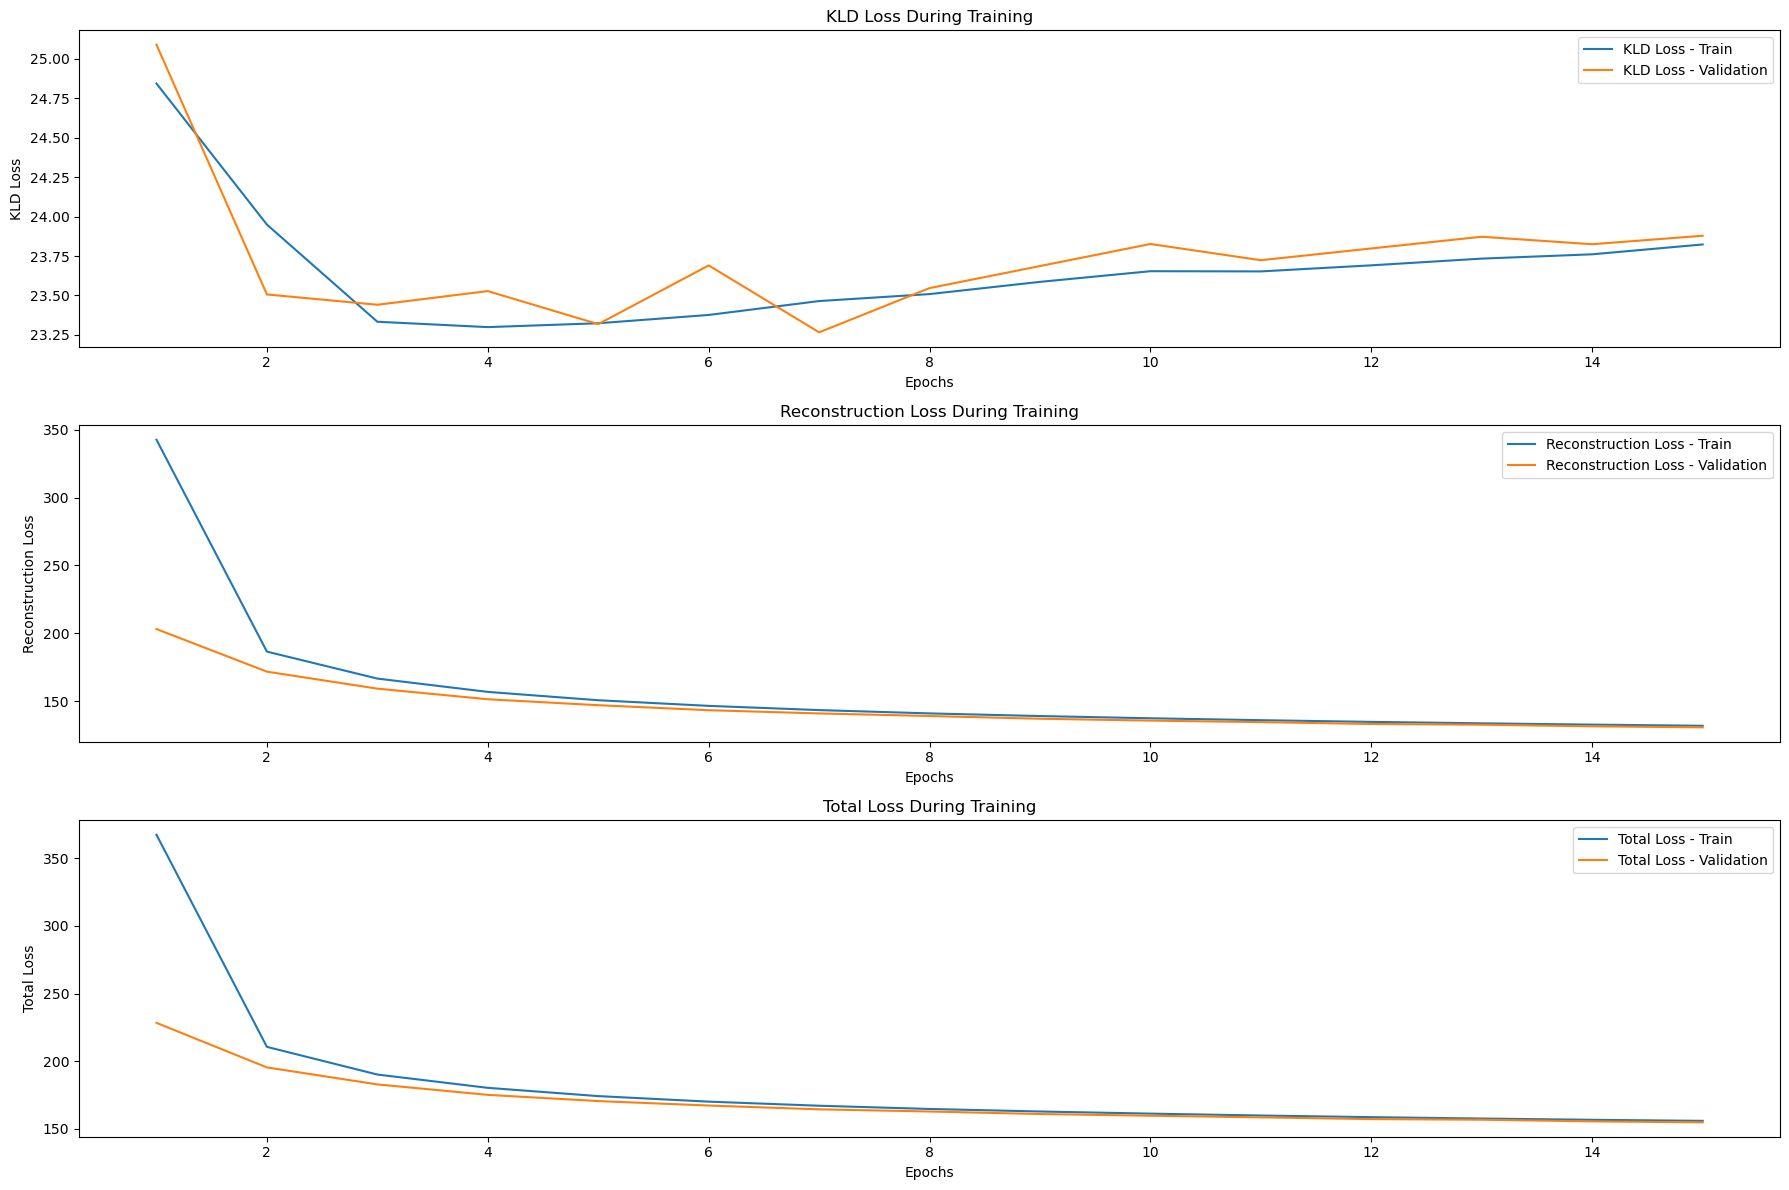

In [16]:
plot_training_history(gaussian_vae_trainer_perceptual_bce_tend.history)

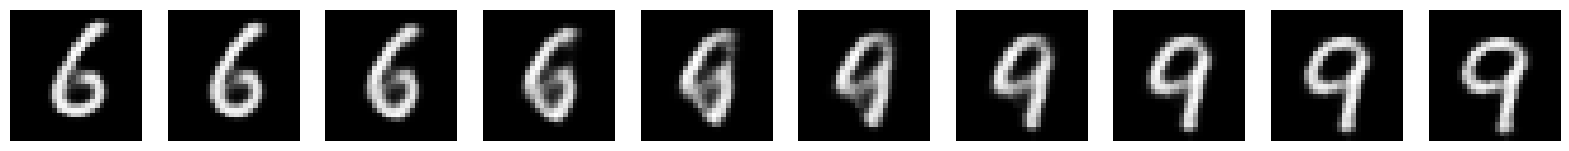

In [20]:
# Interpolation
num = 3
image_6 = test_dataset[indexes_6[num]][0].to(DEVICE)
image_9 = test_dataset[indexes_9[num]][0].to(DEVICE)
interpolate_and_plot(image_6,image_9,model=gaussian_vae_perceptual_bce_tend)

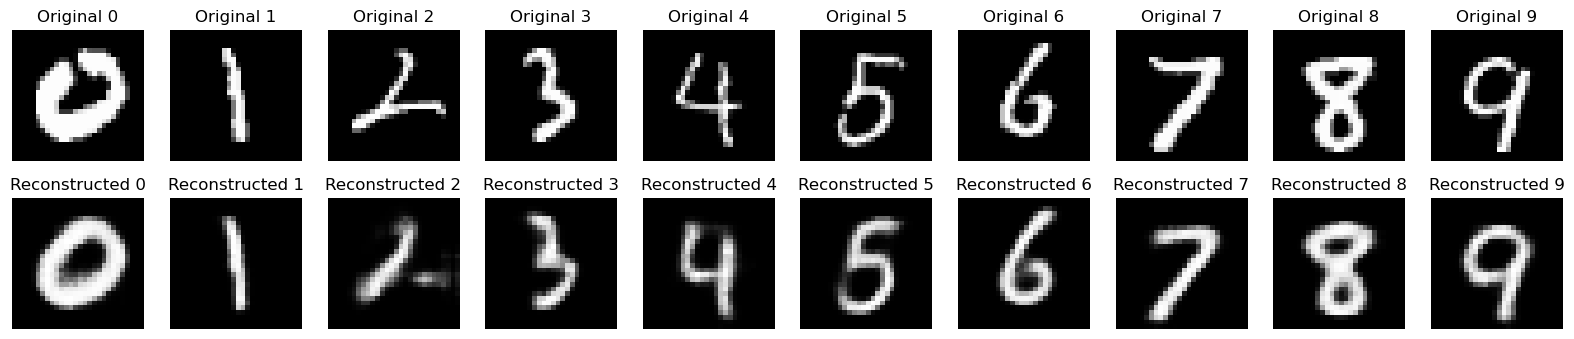

In [29]:
reconstruct_and_plot_digits(test_dataset,dictionary_index,gaussian_vae_perceptual_bce_tend)

In [30]:
save(gaussian_vae_perceptual_bce_tend,gaussian_vae_trainer_perceptual_bce_tend,'models/perceptual_10D_vae_gaussian.pt')

# <a id='toc7_'></a>[FID Scores](#toc0_)

In [4]:
from fid import FID

base_dir = 'models/gaussian(1,2)_improvements/'

## <a id='toc7_1_'></a>[Baselines](#toc0_)

### <a id='toc7_1_1_'></a>[Normal VAE](#toc0_)

In [11]:
normal_state_dict = torch.load('models/normal_vae.pt')['state_dict']
normal_vae = NormalVAE(2,1,2)
normal_vae.load_state_dict(normal_state_dict)
normal_vae = normal_vae.to(DEVICE)
normal_fid_scorer = FID(DEVICE,normal_vae,val_dataset=test_dataset,batch_size=16)
fid = normal_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of VAE ~ N(0,1): {fid}')

Generating images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of fake images ...


  0%|          | 1/625 [00:00<01:20,  7.78batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:32<00:00,  2.94batches/s]


 
FID Score of VAE ~ N(0,1): 131.70117715740136


### <a id='toc7_1_2_'></a>[Gaussian(1,2) VAE](#toc0_)

In [12]:
gaussian_state_dict = torch.load('models/gaussian(1,2)_vae.pt')['state_dict']
gaussian_vae = NormalVAE(2,1,2)
gaussian_vae.load_state_dict(gaussian_state_dict)
gaussian_vae = gaussian_vae.to(DEVICE)
gaussian_fid_scorer = FID(DEVICE,gaussian_vae,val_dataset=test_dataset,batch_size=16)
gaussian_fid = gaussian_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of VAE ~ N(1,2): {gaussian_fid}')

Generating images ...


  0%|          | 1/625 [00:00<02:04,  5.02batches/s]

Calculating features of fake images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:30<00:00,  2.97batches/s]


 
FID Score of VAE ~ N(1,2): 132.01862460809838


## <a id='toc7_2_'></a>[Different Implementations](#toc0_)

### <a id='toc7_2_1_'></a>[Kaiming Init](#toc0_)

In [13]:
kaiming_state_dict = torch.load(f'{base_dir}/kaiming_init.pt')['state_dict']
kaiming_vae = NormalVAE(2,1,2)
kaiming_vae.load_state_dict(kaiming_state_dict)
kaiming_vae = kaiming_vae.to(DEVICE)
kaiming_fid_scorer = FID(DEVICE,kaiming_vae,val_dataset=test_dataset,batch_size=16)
kaiming_fid = kaiming_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of VAE ~ N(1,2) with Kaiming Init: {kaiming_fid}')

Generating images ...


  0%|          | 1/625 [00:00<01:33,  6.66batches/s]

Calculating features of fake images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:32<00:00,  2.94batches/s]


 
FID Score of VAE ~ N(1,2) with Kaiming Init: 150.64741730797664


### <a id='toc7_2_2_'></a>[MAE with Kaiming Init](#toc0_)

In [14]:
mae_kaiming_state_dict = torch.load(f'{base_dir}mae_kaiming_init.pt')['state_dict']
mae_kaiming_vae = NormalVAE(2,1,2)
mae_kaiming_vae.load_state_dict(mae_kaiming_state_dict)
mae_kaiming_vae = mae_kaiming_vae.to(DEVICE)
mae_kaiming_fid_scorer = FID(DEVICE, mae_kaiming_vae, val_dataset=test_dataset, batch_size=16)
mae_kaiming_fid = mae_kaiming_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of VAE ~ N(1,2) with MAE loss: {mae_kaiming_fid}')

Generating images ...


  0%|          | 1/625 [00:00<01:20,  7.77batches/s]

Calculating features of fake images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:31<00:00,  2.95batches/s]


 
FID Score of VAE ~ N(1,2) with MAE loss: 98.24995350511301


### <a id='toc7_2_3_'></a>[MSE with Kaiming Init](#toc0_)

In [15]:
mse_kaiming_state_dict = torch.load(f'{base_dir}mse_kaiming_init.pt')['state_dict']
mse_kaiming_vae = NormalVAE(2,1,2)
mse_kaiming_vae.load_state_dict(mse_kaiming_state_dict)
mse_kaiming_vae = mse_kaiming_vae.to(DEVICE)
mse_kaiming_fid_scorer = FID(DEVICE, mse_kaiming_vae, val_dataset=test_dataset, batch_size=16)
mse_kaiming_fid = mse_kaiming_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of VAE ~ N(1,2) with MAE loss: {mse_kaiming_fid}')

Generating images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of fake images ...


  0%|          | 1/625 [00:00<01:10,  8.88batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:34<00:00,  2.92batches/s]


 
FID Score of VAE ~ N(1,2) with MAE loss: 143.34650442609842


### <a id='toc7_2_4_'></a>[Perceptual Loss with Kaiming Init](#toc0_)

In [16]:
perceptual_kaiming_state_dict = torch.load(f'{base_dir}perceptual_kaiming_init.pt')['state_dict']
perceptual_kaiming_vae = NormalVAE(2,1,2)
perceptual_kaiming_vae.load_state_dict(perceptual_kaiming_state_dict)
perceptual_kaiming_vae = perceptual_kaiming_vae.to(DEVICE)
perceptual_kaiming_fid_scorer = FID(DEVICE, perceptual_kaiming_vae, val_dataset=test_dataset, batch_size=16)
perceptual_kaiming_fid = perceptual_kaiming_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of VAE ~ N(1,2) with Perceptual loss: {perceptual_kaiming_fid}')

Generating images ...


  0%|          | 1/625 [00:00<01:50,  5.65batches/s]

Calculating features of fake images ...


  0%|          | 1/625 [00:00<01:43,  6.05batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:33<00:00,  2.93batches/s]


 
FID Score of VAE ~ N(1,2) with Perceptual loss: 323.55748558411517


### <a id='toc7_2_5_'></a>[Weighted Perceptual Loss with BCE Loss with Kaiming Init](#toc0_)

In [17]:
perceptual_bce_kaiming_state_dict = torch.load(f'{base_dir}perceptual_bce_kaiming_init.pt')['state_dict']
perceptual_bce_kaiming_vae = NormalVAE(2,1,2)
perceptual_bce_kaiming_vae.load_state_dict(perceptual_bce_kaiming_state_dict)
perceptual_bce_kaiming_vae = perceptual_bce_kaiming_vae.to(DEVICE)
perceptual_bce_kaiming_fid_scorer = FID(DEVICE, perceptual_bce_kaiming_vae, val_dataset=test_dataset, batch_size=16)
perceptual_bce_kaiming_fid = perceptual_bce_kaiming_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of VAE with Perceptual BCE Kaiming Init: {perceptual_bce_kaiming_fid}')

Generating images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of fake images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:33<00:00,  2.93batches/s]


 
FID Score of VAE with Perceptual BCE Kaiming Init: 180.73248309445486


### <a id='toc7_2_6_'></a>[Weighted Perceptual Loss with MSE Loss with Kaiming Init](#toc0_)

In [18]:
perceptual_mse_kaiming_state_dict = torch.load(f'{base_dir}perceptual_mse_kaiming_init.pt')['state_dict']
perceptual_mse_kaiming_vae = NormalVAE(2,1,2)
perceptual_mse_kaiming_vae.load_state_dict(perceptual_mse_kaiming_state_dict)
perceptual_mse_kaiming_vae = perceptual_mse_kaiming_vae.to(DEVICE)
perceptual_mse_kaiming_fid_scorer = FID(DEVICE, perceptual_mse_kaiming_vae, val_dataset=test_dataset, batch_size=16)
perceptual_mse_kaiming_fid = perceptual_mse_kaiming_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of VAE with Perceptual MSE Kaiming Init: {perceptual_mse_kaiming_fid}')

Generating images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of fake images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:33<00:00,  2.93batches/s]


 
FID Score of VAE with Perceptual MSE Kaiming Init: 176.88968862580626


## <a id='toc7_3_'></a>[10D Latent Space](#toc0_)

### <a id='toc7_3_1_'></a>[BCE Loss](#toc0_)

In [19]:
vae_10d_gaussian_state_dict = torch.load(f'models/10D_vae_gaussian.pt')['state_dict']
vae_10d_gaussian = NormalVAE(10,1,2)  # Assuming the class constructor takes the latent dimension as the first argument
vae_10d_gaussian.load_state_dict(vae_10d_gaussian_state_dict)
vae_10d_gaussian = vae_10d_gaussian.to(DEVICE)
vae_10d_gaussian_fid_scorer = FID(DEVICE,vae_10d_gaussian,val_dataset=test_dataset,batch_size=16)
vae_10d_gaussian_fid = vae_10d_gaussian_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of 10D VAE ~ N(1,2) with BCE Loss: {vae_10d_gaussian_fid}')

Generating images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of fake images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:36<00:00,  2.89batches/s]


 
FID Score of 10D VAE ~ N(1,2) with BCE Loss: 79.72448149472473


### <a id='toc7_3_2_'></a>[Weighted Perceptual Loss with BCE Loss](#toc0_)

In [20]:
perceptual_vae_10d_gaussian_state_dict = torch.load(f'models/perceptual_10D_vae_gaussian.pt')['state_dict']
perceptual_vae_10d_gaussian = NormalVAE(10,1,2)  # Assuming the class constructor takes the latent dimension as the first argument
perceptual_vae_10d_gaussian.load_state_dict(perceptual_vae_10d_gaussian_state_dict)
perceptual_vae_10d_gaussian = perceptual_vae_10d_gaussian.to(DEVICE)
perceptual_vae_10d_gaussian_fid_scorer = FID(DEVICE, perceptual_vae_10d_gaussian, val_dataset=test_dataset, batch_size=16)
perceptual_vae_10d_gaussian_fid = perceptual_vae_10d_gaussian_fid_scorer.calculate_fid()
print(' ')
print(f'FID Score of VAE ~ N(1,2) with Weighted Perceptual Loss with BCE Loss: {perceptual_vae_10d_gaussian_fid}')

Generating images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of fake images ...


  0%|          | 0/625 [00:00<?, ?batches/s]

Calculating features of real images ...


100%|██████████| 625/625 [03:31<00:00,  2.96batches/s]


 
FID Score of VAE ~ N(1,2) with Weighted Perceptual Loss with BCE Loss: 90.5802173204686


# <a id='toc8_'></a>[Additional](#toc0_)

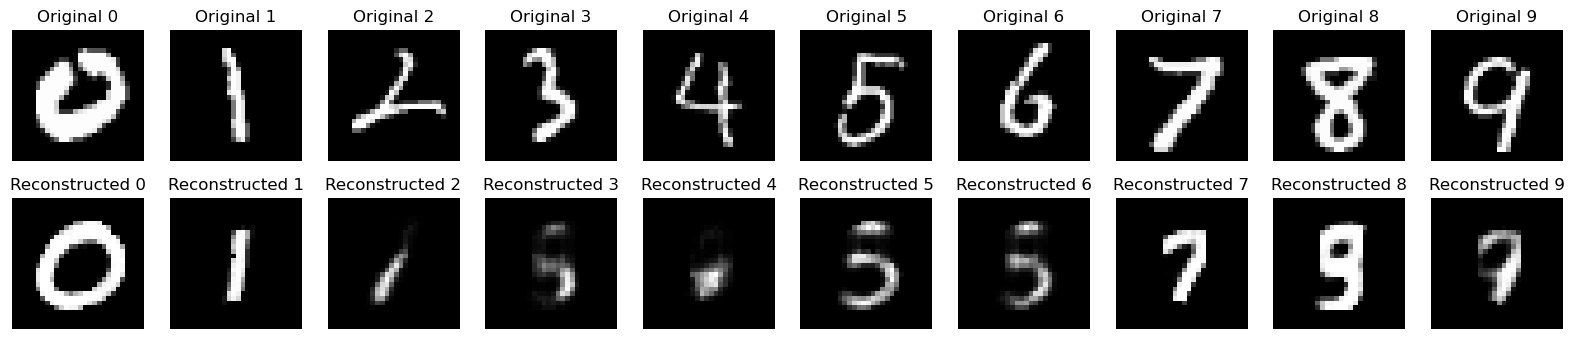

In [26]:
# Reconstruction of MAE VAE
reconstruct_and_plot_digits(test_dataset,dictionary_index,mae_kaiming_vae)

In [32]:
params = 0
for param in normal_vae.parameters():
    params += param.numel()
print(f"Number of parameters in each model: {params}")

Number of parameters in each model: 210821
